# General py4DSTEM Analysis

## Import Modules

In [2]:
## Import all necessary modules. Might be neccessary to edit depending on file path

import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle 
from matplotlib.patches import Circle, Ellipse
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import medfilt
from scipy.ndimage import sobel

from py4DSTEM.process.diskdetection import * 
from py4DSTEM.process.utils import get_CoM,radial_integral, get_maxima_1D 
from py4DSTEM.process.calibration import *
from py4DSTEM.process.latticevectors import *
from py4DSTEM.process.fit import fit_2D

from py4DSTEM.file.datastructure import DiffractionSlice, RealSlice
from py4DSTEM.file.io import  read
from py4DSTEM.file.io.native import save, append


# Import by personal display preference 
# import matplotlib
# matplotlib.use("Qt4Agg")
%matplotlib notebook

In [1]:
#Hello

<IPython.core.display.Javascript object>


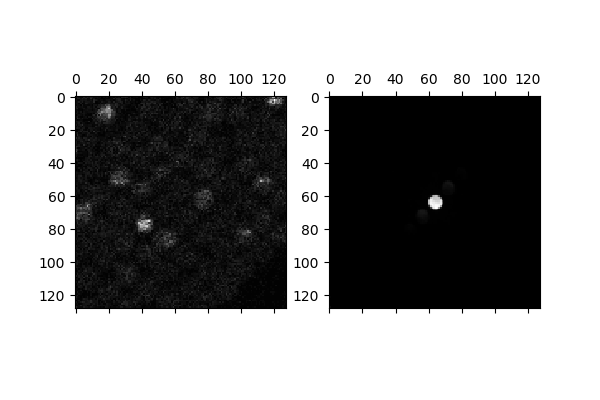

In [22]:
## Load 4DSTEM file

fp = "/Users/micol/Box Sync/Research/Python/newpy4DSTEM/"
filename = "02_1p3Mx_770mm_1p74mrad_50x_50y_100z_432step_x128_y128.raw"
sp = "/Users/micol/Box Sync/Research/Python/newpy4DSTEM/"
savename = "demo.h5"

# Set load= based on detector, axis are presented in (rx,ry,kx,ky)
dc,_ = py4DSTEM.file.io.read(fp+filename, ft='empad')
# Check real space and diffraction space image
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(6,4))
ax1.matshow(dc.data[:,:,30,30]) # Real space
ax2.matshow(dc.data[30,30,:,:]) # Diffraction plane

## Bragg Vector Map

### Vacuum Probe

In [8]:
"""
Necessary imports:
import py4DSTEM
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle 
from py4DSTEM.process.diskdetection import * 
from py4DSTEM.process.utils import get_CoM

Necessary data: Datacube (4D image)
Optional: Vacuum scan (4D, 3D, or 2D image)
"""

'\nNecessary imports:\nimport py4DSTEM\nimport numpy as np\nimport matplotlib.pyplot as plt\nfrom matplotlib.patches import Rectangle \nfrom py4DSTEM.process.diskdetection import * \nfrom py4DSTEM.process.utils import get_CoM\n\nNecessary data: Datacube (4D image)\nOptional: Vacuum scan (4D, 3D, or 2D image)\n'

<IPython.core.display.Javascript object>


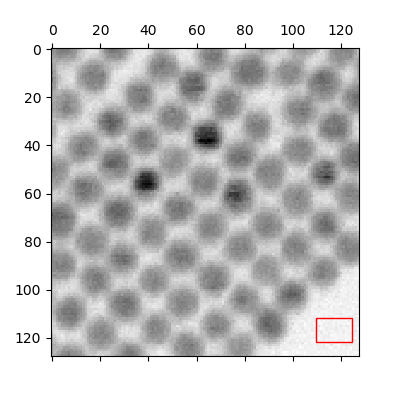

In [9]:
## Run this cell to find ROI over vacuum space. If you already have a vacuum scan, skip this cell.
xmin,xmax=112,122
ymin,ymax=110,125
ROI = np.zeros_like(dc.data[:,:,0,0],dtype=bool)
ROI[xmin:xmax,ymin:ymax] = True

# Display
ave_im = np.average(dc.data,axis=(2,3))
roi_rect = Rectangle(xy=(ymin-0.5,xmin-0.5),width=ymax-ymin,height=xmax-xmin,fill=False,color='r')

fig,ax=plt.subplots(figsize=(4,4))
ax.matshow(ave_im,cmap='gray')
ax.add_patch(roi_rect)
plt.show()

100%|██████████| 149/149 [00:00<00:00, 380.31it/s]


<IPython.core.display.Javascript object>


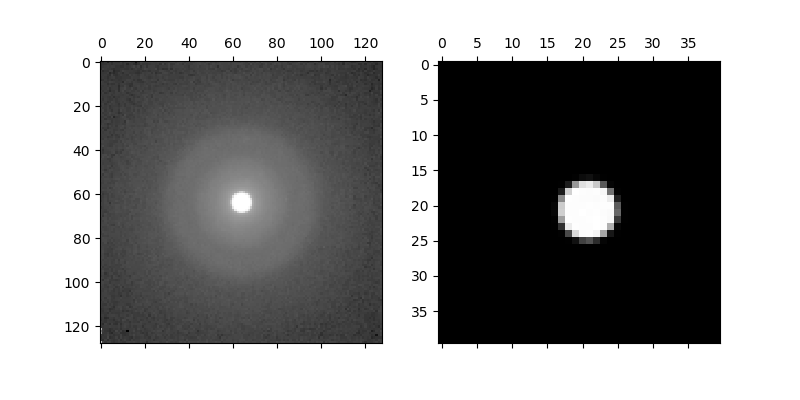

In [10]:
"""
Finding the probe. If you aquired a vacuum scan, use the following functions depending on the type of vacuum scan: 
{get_probe_from_vacuum_4Dscan}, {get_probe_from_vacuum_3Dstack}, {get_probe_from_vacuum_2Dimage}
If you don't have a vacuum scan, use {get_probe_from_4Dscan_ROI} to aquire an approximate vacuum probe in a region of your scan that is over vacuum. 
If there is no approximate vacuum region in your real space image, you can also use {get_probe_synthetic}.
"""


## Get average probe
mask_threshold = 0 # min threshold relative to probe peak
mask_expansion = 1 # iterations of scipy.ndimage.morphology.binary_dilation (# of pixels to expand mask by)
mask_opening = 1   # iterations of scipy.ndimage.morphology.binary_opening
verbose = False


# Vacuum ROI
probe = get_probe_from_4Dscan_ROI(dc, ROI=ROI,
                                       mask_threshold=mask_threshold,
                                       mask_expansion=mask_expansion,
                                       mask_opening=mask_opening,
                                       verbose=verbose)

# Vacuum scan
"""
probe = get_probe_from_vacuum_4Dscan(vac_dc, mask_threshold=mask_threshold,
                                       mask_expansion=mask_expansion,
                                       mask_opening=mask_opening,
                                       verbose=verbose)
# or 
probe = get_probe_from_vacuum_3Dstack(data, mask_threshold=mask_threshold,
                                       mask_expansion=mask_expansion,
                                       mask_opening=mask_opening)
# or 
probe = get_probe_from_vacuum_2Dimage(data, mask_threshold=mask_threshold,
                                       mask_expansion=mask_expansion,
                                       mask_opening=mask_opening)
"""

# No vacuum region
"""
probe_r = 5
probe_w = 1
probe = get_probe_synthetic(probe_r,probe_w,dc.Q_Nx,dc.Q_Ny)
"""

# Find CoM pixel of probe
xCoM_init,yCoM_init = get_CoM(probe)

# Display
rad = 20     # For zoomed-in display  

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
ax1.matshow(np.log(probe+1),cmap='gray')
ax2.matshow(probe[int(xCoM_init)-rad:int(xCoM_init)+rad,int(yCoM_init)-rad:int(yCoM_init)+rad])
plt.show()

<IPython.core.display.Javascript object>


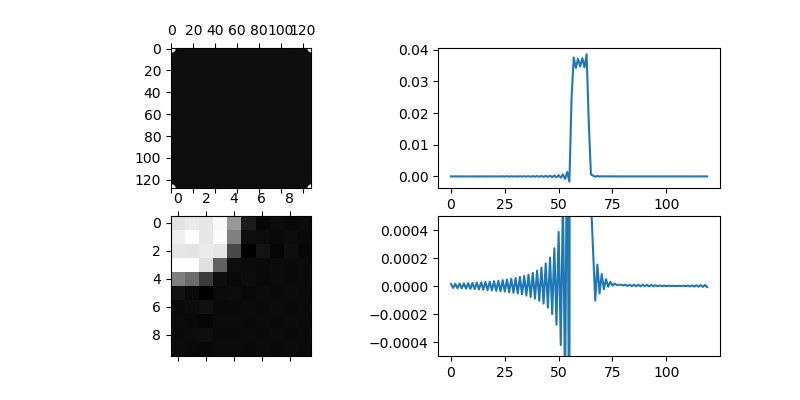

In [12]:
## Generate vacuum probe kernel
"""
Generate probe kernel. This shifts the center of the probe to the corners of the array. 
You may also subtract a gaussian/logistic trench such that the kerneln integrates to zero. 
This process will change depending on quality of bragg disk detection.
"""
# No subtraction
probe_kernel = get_probe_kernel(probe)

# Gaussian subtraction
"""
sigma_probe_scale = 1 
probe_kernel = get_probe_kernel_subtrgaussian(probe, sigma_probe_scale=sigma_probe_scale)
"""

# Logistic trench
"""
log_rad = 5 # inner radius of trench
trenchwidth = 5
blurwidth = 2
probe_kernel = get_probe_kernel_logistictrench(probe, log_rad, trenchwidth, blurwidth)
"""

# Display probe kernel and line profile
rad=10
lineprofile_length=60
lineprofile_width=2

xCom,yCoM = np.unravel_index(np.argmax(probe_kernel),(dc.Q_Nx,dc.Q_Ny))
line_profile_left = np.sum(probe_kernel[-lineprofile_length:,:lineprofile_width],axis=(1))
line_profile_right = np.sum(probe_kernel[:lineprofile_length,:lineprofile_width],axis=(1))
line_profile = np.concatenate([line_profile_left,line_profile_right])

fig,((ax1,ax3),(ax2,ax4))=plt.subplots(2,2,figsize=(8,4))
ax1.matshow(probe_kernel)
ax2.matshow(probe_kernel[:rad,:rad])
ax3.plot(np.arange(len(line_profile)),line_profile)
ax4.plot(np.arange(len(line_profile)),line_profile)
ax4.set_ylim(-0.0005,0.0005)
plt.show()

### Bragg Disk Detection

In [ ]:
"""
Necessary imports:
import py4DSTEM
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import sobel

from py4DSTEM.process.diskdetection import * 

Necessary data: 
Datacube (4D image), probe kernel
"""

In [13]:
"""
Determine parameters used to detect bragg disks. Use {find_Bragg_disks_single_DP} to find disks at a single scan position or 
{find_Bragg_disks_selected} to test multiple scan positions in serial. 
If probe kernel is in Fourier space, you can also try {find_Bragg_disks_single_DP_FK}. 
If you are having trouble with detections, you may also apply a Sobel filter to the DP and probe kernel using {sobel}. 
"""

## Optional: Sobel filter diffraction space and probe 
#(note: dc axis 2 :: probe_kernel axis 0)

dcs,_ = py4DSTEM.file.io.read(fp+filename, ft='empad')

# 1 directional filter
dcs.data = sobel(dcs.data,axis=2)
pks = sobel(probe_kernel,axis=0)

# 2-directional filter
'''
dcs_dx = sobel(dcs.data,axis=2)
dcs_dy = sobel(dcs.data,axis=3)

dcs.data = np.sqrt(dcs_dx**2+dcs_dy**2)

pk_dx = sobel(probe_kernel,axis=0)
pk_dy = sobel(probe_kernel,axis=1)
pks = np.sqrt(pk_dx**2+pk_dy**2)
'''

'\ndcs_dx = sobel(dcs.data,axis=2)\ndcs_dy = sobel(dcs.data,axis=3)\n\ndcs.data = np.sqrt(dcs_dx**2+dcs_dy**2)\n\npk_dx = sobel(probe_kernel,axis=0)\npk_dy = sobel(probe_kernel,axis=1)\npks = np.sqrt(pk_dx**2+pk_dy**2)\n'

Analyzed 3 diffraction patterns in 0h 0m 0s


<IPython.core.display.Javascript object>


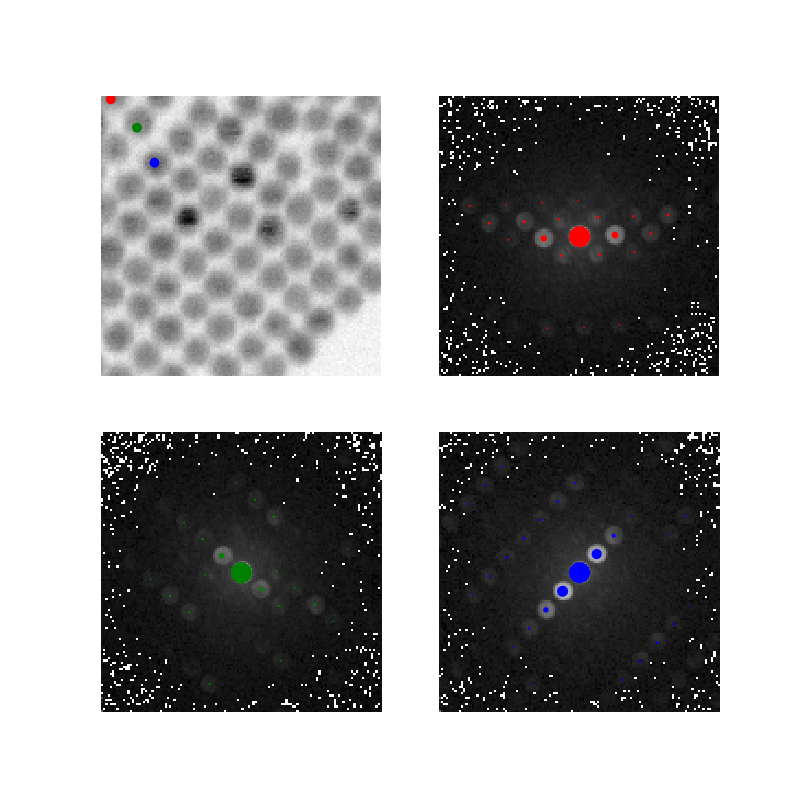

E:\ProgramFiles\PYTHON\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in power
E:\ProgramFiles\PYTHON\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in power
E:\ProgramFiles\PYTHON\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in power


In [14]:
## Determining detection parameters

# Select scan positions to test parameters
Rxs=(1,14,30)
Rys=(4,16,24)

# Peak detection parameters
corrPower = 1      # 1 == cross correaltion, 0 == phase correlation, with intermediate values giving various hybrids.
sigma = .5         # STD of gaussian smoothin applied to CC 
edgeBoundary = 10  # Min distance from DP edge
maxNumPeaks = 80   # Max peaks to return
minPeakSpacing = 5 # Min spacing between peaks
minRelativeIntensity = 0.0005 # Min intensity relative to "relativeToPeak" numbered max peak
relativeToPeak = 0
subpixel = 'poly' #'none' # switch to 'multicorr' for better accuracy, in which case need to add upsample_factor param

# Display parameters
power = 0.3
size_scale_factor = 200       # Set to zero to make all points the same size

############################

# Find peak at single position
"""
peaks = find_Bragg_disks_single_DP(dcs.data[30,30,:,:], pks, # w/ sobel
                                  corrPower=corrPower,
                                  sigma=sigma,
                                  edgeBoundary=edgeBoundary,
                                  minRelativeIntensity=minRelativeIntensity,
                                  relativeToPeak=relativeToPeak,
                                  minPeakSpacing=minPeakSpacing,
                                  maxNumPeaks=maxNumPeaks,
                                  subpixel=subpixel)
"""

# Find peaks at selected positions
peaks = find_Bragg_disks_selected(dcs, pks, Rxs, Rys, # w/ sobel
                                  corrPower=corrPower,
                                  sigma=sigma,
                                  edgeBoundary=edgeBoundary,
                                  minRelativeIntensity=minRelativeIntensity,
                                  relativeToPeak=relativeToPeak,
                                  minPeakSpacing=minPeakSpacing,
                                  maxNumPeaks=maxNumPeaks,
                                  subpixel=subpixel)

# Show
fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(8,8))
ax11.matshow(np.average(dc.data,axis=(2,3)))
ax11.scatter(Rys,Rxs,color=('r','g','b'))
ioi = ax12.matshow(dc.data[Rxs[0],Rys[0],:,:]**power)
ax21.matshow(dc.data[Rxs[1],Rys[1],:,:]**power)
ax22.matshow(dc.data[Rxs[2],Rys[2],:,:]**power)

if size_scale_factor == 0:
    ax12.scatter(peaks[0].data['qy'],peaks[0].data['qx'],color='r')
    ax21.scatter(peaks[1].data['qy'],peaks[1].data['qx'],color='g')
    ax22.scatter(peaks[2].data['qy'],peaks[2].data['qx'],color='b')
else:
    ax12.scatter(peaks[0].data['qy'],peaks[0].data['qx'],color='r',s=size_scale_factor*peaks[0].data['intensity']/np.max(peaks[0].data['intensity']))
    ax21.scatter(peaks[1].data['qy'],peaks[1].data['qx'],color='g',s=size_scale_factor*peaks[1].data['intensity']/np.max(peaks[1].data['intensity']))
    ax22.scatter(peaks[2].data['qy'],peaks[2].data['qx'],color='b',s=size_scale_factor*peaks[2].data['intensity']/np.max(peaks[2].data['intensity']))

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')
vmin, vmax = ioi.get_clim()

plt.show()

In [15]:
"""
Once parameters are determined, use {find_Bragg_disks} to generate full bragg disk point list array. 
You may also apply additional thresholding to point list array using {threshold_Braggpeaks}.
"""

## Using accepted parameters, find all peaks

braggpeaks_uncorrected = find_Bragg_disks(dcs, pks, # w/ sobel
                              corrPower=corrPower,
                              sigma=sigma,
                              edgeBoundary=edgeBoundary,
                              minRelativeIntensity=minRelativeIntensity,
                              minPeakSpacing=minPeakSpacing,
                              maxNumPeaks=maxNumPeaks,
                              subpixel=subpixel)
braggpeaks_uncorrected.name = 'braggpeaks'

Finding Bragg Disks: 100%|██████████| 16.4k/16.4k [01:00<00:00, 272DP/s]

Analyzed 16384 diffraction patterns in 0h 1m 0s


<IPython.core.display.Javascript object>


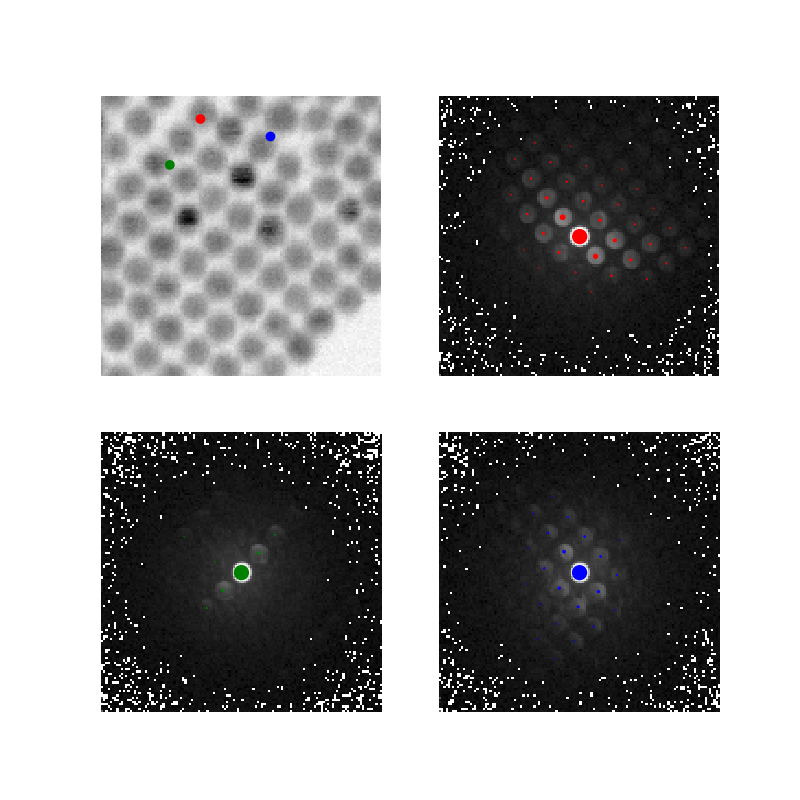

E:\ProgramFiles\PYTHON\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in power
  app.launch_new_instance()
E:\ProgramFiles\PYTHON\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in power
E:\ProgramFiles\PYTHON\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in power


In [16]:
## Show detection 

# Select scan positions to varify detection
xs=(10,31,18)
ys=(45,31,77)

# Display parameter
power=0.3

# Show
fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(8,8))

ax11.matshow(np.average(dc.data,axis=(2,3)))
ax11.scatter(ys,xs,color=('r','g','b'))

ax12.matshow(dc.data[xs[0],ys[0],:,:]**power)
ax21.matshow(dc.data[xs[1],ys[1],:,:]**power)
ax22.matshow(dc.data[xs[2],ys[2],:,:]**power)

peaks0 = braggpeaks_uncorrected.get_pointlist(xs[0],ys[0])
peaks1 = braggpeaks_uncorrected.get_pointlist(xs[1],ys[1])
peaks2 = braggpeaks_uncorrected.get_pointlist(xs[2],ys[2])

ax12.scatter(peaks0.data['qy'],peaks0.data['qx'],color='r',s=100*peaks0.data['intensity']/np.max(peaks0.data['intensity']))
ax21.scatter(peaks1.data['qy'],peaks1.data['qx'],color='g',s=100*peaks1.data['intensity']/np.max(peaks1.data['intensity']))
ax22.scatter(peaks2.data['qy'],peaks2.data['qx'],color='b',s=100*peaks2.data['intensity']/np.max(peaks2.data['intensity']))

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')
plt.show()

100%|██████████| 16384/16384 [00:12<00:00, 1350.45it/s]


<IPython.core.display.Javascript object>


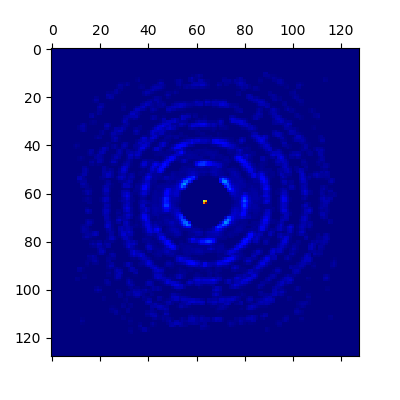

In [17]:
"""
Sum bragg disk point list array to generate bragg vector map (BVM) using {get_bragg_vector_map}. 
"""
## Generate full bragg vector map

braggvectormap_uncorrected = get_bragg_vector_map(braggpeaks_uncorrected,dc.Q_Nx,dc.Q_Ny)

# Show
fig,ax = plt.subplots(figsize=(4,4))
ax.matshow(braggvectormap_uncorrected**0.25,cmap='jet')
plt.show()

### Shift Correction 

In [18]:
"""
Necessary imports:
import py4DSTEM
import numpy as np
import matplotlib.pyplot as plt

from py4DSTEM.process.diskdetection import * 
from py4DSTEM.process.calibration import *
from py4DSTEM.process.utils import get_CoM
from py4DSTEM.process.fit import fit_2D

Necessary data: 
Datacube (4D image), bragg peaks point list array
"""

'\nNecessary imports:\nimport py4DSTEM\nimport numpy as np\nimport matplotlib.pyplot as plt\n\nfrom py4DSTEM.process.calibration import *\nfrom py4DSTEM.process.utils import get_CoM\nfrom py4DSTEM.process.fit import fit_2D\n\n\nNecessary data: \nDatacube (4D image), bragg peaks point list array\n'

100%|██████████| 16384/16384 [00:11<00:00, 1391.23it/s]


<IPython.core.display.Javascript object>


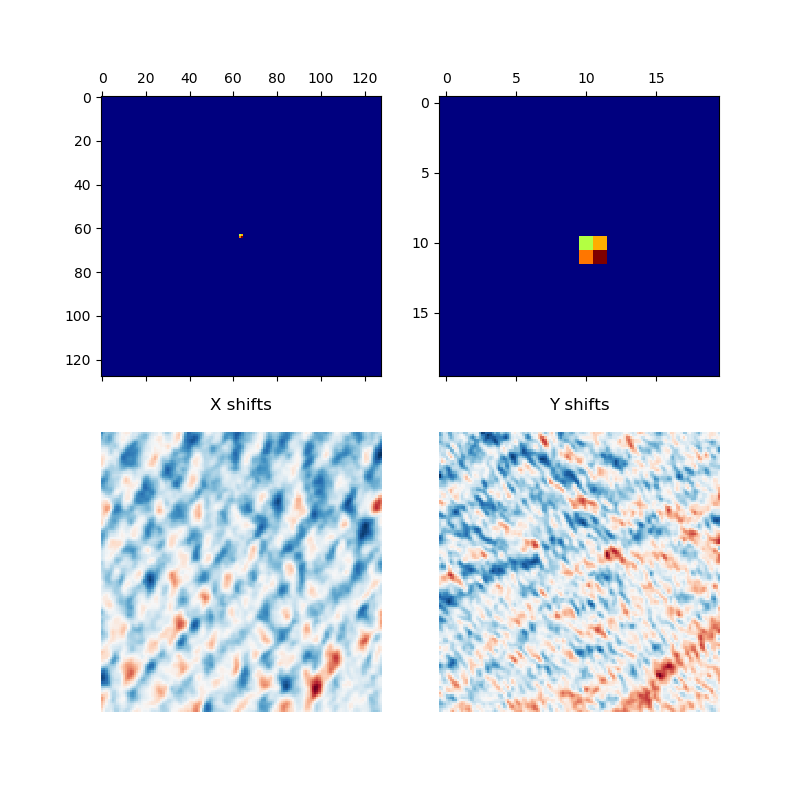

(-0.5, 127.5, 127.5, -0.5)

In [14]:
"""
Find x and y shift matrices for DP using max intensity point of each bragg peak point list using {get_diffraction_shifts}.
"""
## Get diffraction shifts

# Shift map parameters
findcenter = 'CoM'   # Must be 'CoM' or 'max'

# Find shift matrices and center bragg peak
xshifts, yshifts, braggvectormap_center = get_diffraction_shifts(braggpeaks_uncorrected,
                                                                 dc.Q_Nx, dc.Q_Ny,
                                                                 findcenter=findcenter)

# Find CoM of Bragg vector map
x0,y0 = get_CoM(braggvectormap_center)

# Display parameters
rad = 10             
power = 0.25

# Display center bragg peak and x,y shifts

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(8,8))
ax11.matshow(braggvectormap_center**power,cmap='jet')
ax12.matshow(braggvectormap_center[int(x0-rad):int(x0+rad),int(y0-rad):int(y0+rad)]**power,cmap='jet')
ax21.matshow(xshifts,cmap="RdBu")
ax22.matshow(yshifts,cmap="RdBu")
plt.show()

ax21.set_title('X shifts')
ax22.set_title('Y shifts')

ax21.axis('off')
ax22.axis('off')

<IPython.core.display.Javascript object>


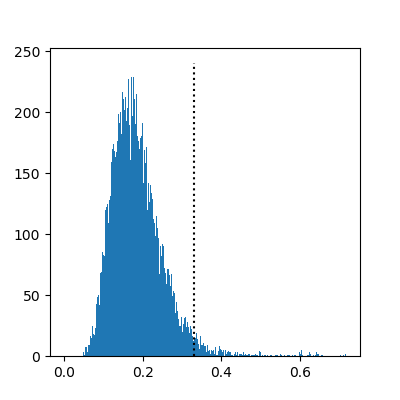

<IPython.core.display.Javascript object>


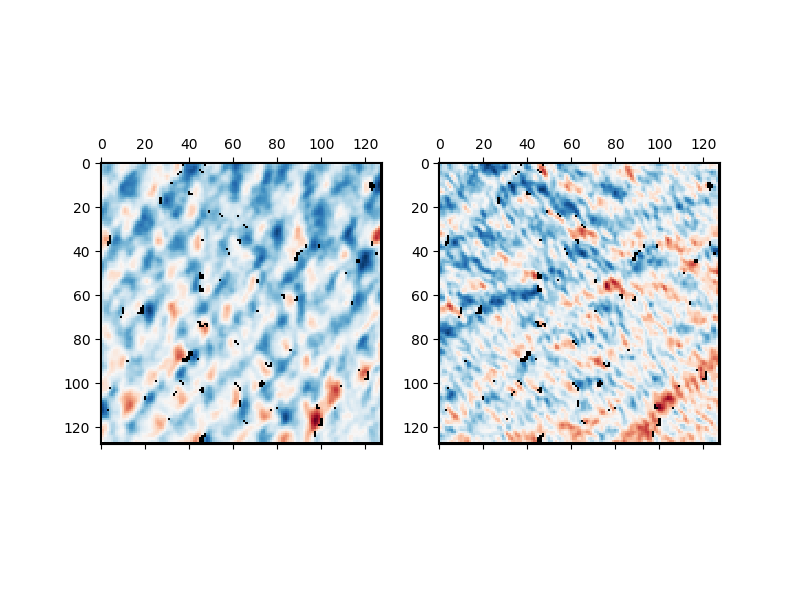

In [15]:
"""
Mask outliers using {find_outlier_shifts} and fit matrices to some function, 
typically {py4DSTEM.process.fit.plane} or {py4DSTEM.process.fit.parabola}, using {fit_2D}.
"""
## Find outliers

# Outlier parameters
n_sigma = 6 # number of sigma above average score of each pixel to mask
edge_boundary = 1 # pixels away from boundary to mask
n_bins = 400 # number of bins for score histogram

mask,n,bins,cutoff = find_outlier_shifts(xshifts,yshifts,n_sigma=n_sigma,edge_boundary=edge_boundary,n_bins=n_bins)

# Find masked shift maps
xshifts_masked = np.ma.masked_array(xshifts, mask)
yshifts_masked = np.ma.masked_array(yshifts, mask)
mask_display = np.ma.masked_array(mask, mask==False)

# Display scores histogram
fig,ax = plt.subplots(figsize=(4,4))
ax.bar(bins[:-1]+(bins[1]-bins[0])/2., n, (bins[1]-bins[0]), align='center')
ax.vlines(cutoff,0,ax.get_ylim()[1],linestyle=':')
plt.show()

# Display masked shift maps
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,6))
ax1.matshow(xshifts_masked,cmap="RdBu")
ax2.matshow(yshifts_masked,cmap="RdBu")
ax1.matshow(mask_display)
ax2.matshow(mask_display)
plt.show()

<IPython.core.display.Javascript object>


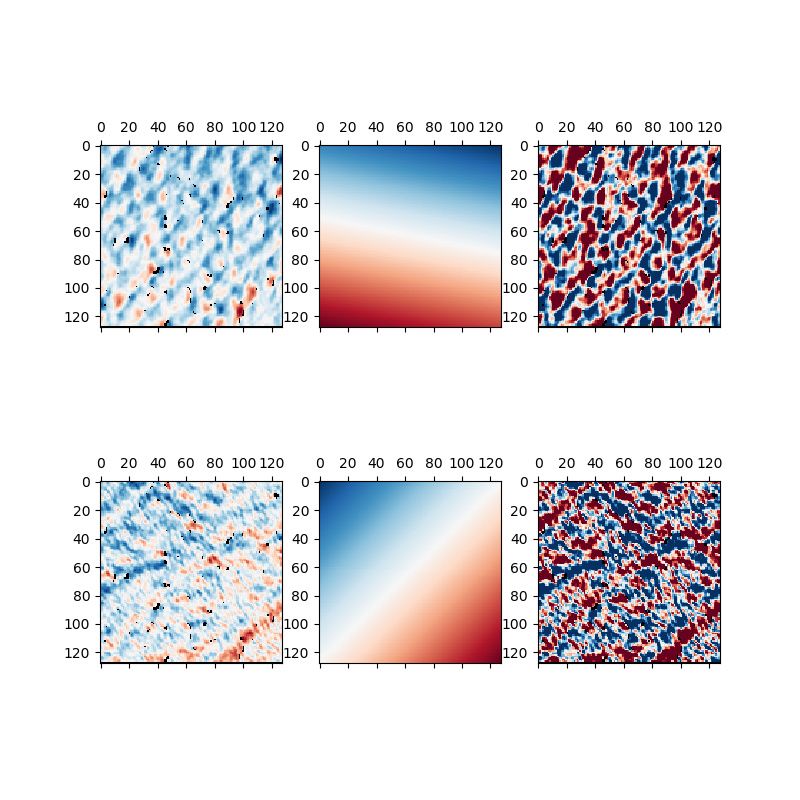

In [16]:
## Fit the diffraction shifts

# Select fit type
fit_function = py4DSTEM.process.fit.plane        
#fit_function = py4DSTEM.process.fit.parabola

# Fit
xshifts_fit = np.zeros_like(xshifts)
yshifts_fit = np.zeros_like(yshifts)
popt_x, pcov_x, xshifts_fit = fit_2D(fit_function, xshifts, data_mask=mask==False)
popt_y, pcov_y, yshifts_fit = fit_2D(fit_function, yshifts, data_mask=mask==False)
residuals_x = xshifts-xshifts_fit
residuals_y = yshifts-yshifts_fit
residuals_x[mask] = 0
residuals_y[mask] = 0

# Show
fig,((ax11,ax12,ax13),(ax21,ax22,ax23))=plt.subplots(2,3,figsize=(8,8))
ax11.matshow(xshifts,cmap="RdBu")
ax21.matshow(yshifts,cmap="RdBu")
ax12.matshow(xshifts_fit,cmap="RdBu")
ax22.matshow(yshifts_fit,cmap="RdBu")
ax13.matshow(residuals_x,cmap="RdBu",vmin=np.median(residuals_x)-np.std(residuals_x),vmax=np.median(residuals_x)+np.std(residuals_x))
ax23.matshow(residuals_y,cmap="RdBu",vmin=np.median(residuals_y)-np.std(residuals_y),vmax=np.median(residuals_y)+np.std(residuals_y))
ax11.matshow(mask_display)
ax21.matshow(mask_display)
ax13.matshow(mask_display)
ax23.matshow(mask_display)
plt.show()

100%|██████████| 16384/16384 [00:11<00:00, 1393.93it/s]


<IPython.core.display.Javascript object>


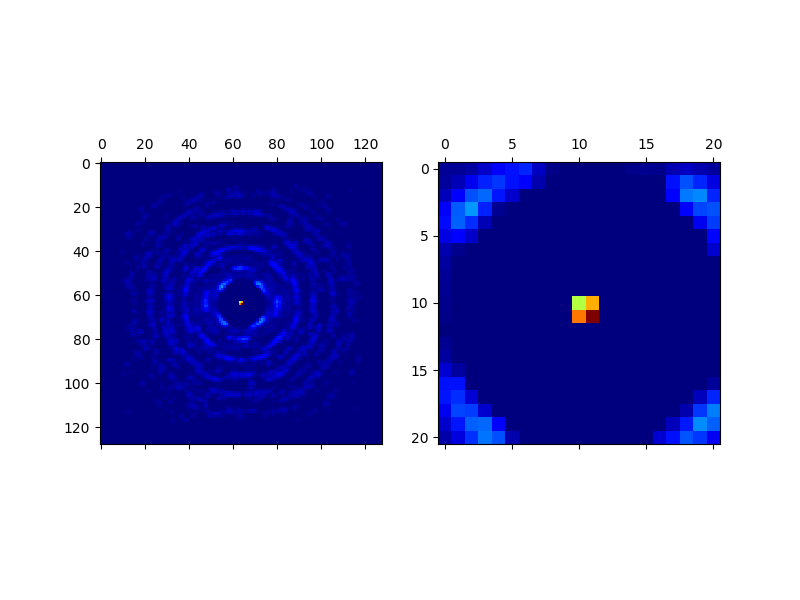

In [17]:
"""
Apply fitted shift matrices to bragg point list array using shift_braggpeaks and generate corrected bragg vector map.
"""

## Apply shifts to bragg peak point list array and generate corrected bragg vector map

braggpeaks_shiftcorrected = shift_braggpeaks(braggpeaks_uncorrected, xshifts_fit, yshifts_fit)

braggvectormap_shiftcorrected = get_bragg_vector_map(braggpeaks_shiftcorrected,dc.Q_Nx,dc.Q_Ny)

## Show
power = 0.25
rad = 10
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8,6))
ax1.matshow(braggvectormap_shiftcorrected**power,cmap='jet')
ax2.matshow(braggvectormap_shiftcorrected[int(x0-rad):int(x0+rad)+1,int(y0-rad):int(y0+rad)+1]**power,cmap='jet')

### Elliptical Distortion Correction

In [ ]:
"""
Necessary imports:
import py4DSTEM
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Ellipse
from scipy.ndimage.filters import gaussian_filter

from py4DSTEM.process.diskdetection import *
from py4DSTEM.process.calibration import *
from py4DSTEM.process.utils import radial_integral, get_maxima_1D 


Necessary data: 
Datacube (4D image), bragg peaks point list array
"""

<IPython.core.display.Javascript object>


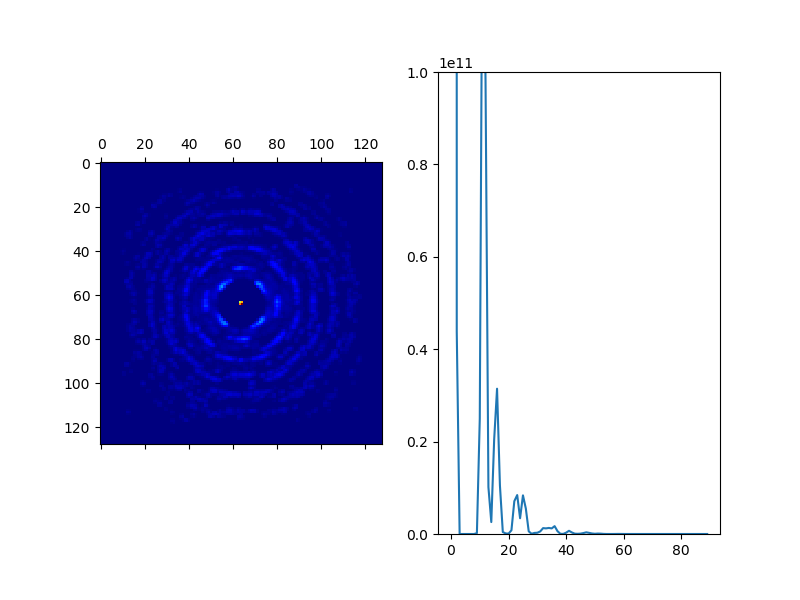

In [20]:
## Show Bragg vector map, calculate radial integral

# Display parameters
ymax=1e11
power=0.25

# find BVM center
x0,y0 = np.unravel_index(np.argmax(gaussian_filter(braggvectormap_shiftcorrected,2)),(dc.Q_Nx,dc.Q_Ny))
# Radial integral
radial_profile = radial_integral(braggvectormap_shiftcorrected,x0,y0,dr=1)[0]

# Show
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,6))
ax1.matshow(braggvectormap_shiftcorrected**power,cmap='jet')
ax2.plot(np.arange(len(radial_profile)),radial_profile)
ax2.set_ylim(0,ymax)
plt.show()

<IPython.core.display.Javascript object>


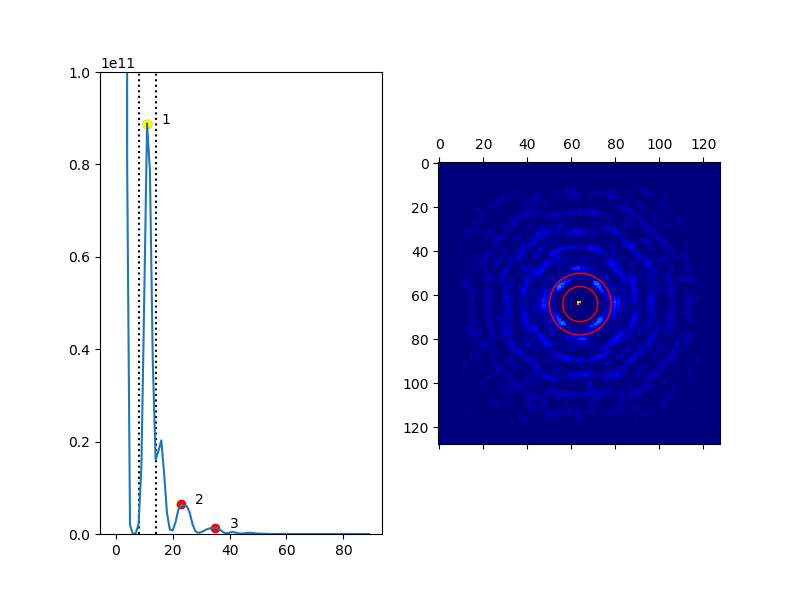

In [21]:
## Specify annular fitting region
## Get annulus center from selected radial profile maximum, specify annulus width

# get_maxima_1D parameters
sigma = 1                   # STD of gaussian smoothing applied to radial profile
minSpacing = 10             # Min spacing of local maxima 
minRelativeIntensity = 0.01 # Min intensity relative to "relativeToPeak" numbered max peak
relativeToPeak = 1

# Select a maximum and annulus width
selected_index = 1 # number peak away from center
annulus_width = 6  # radius of annulus for fitting 

# Display params
text_offset = 5
power = 0.25

# Find radial maxima locations
maxima = get_maxima_1D(radial_profile, sigma=sigma, minSpacing=minSpacing,
                       minRelativeIntensity=minRelativeIntensity,
                       relativeToPeak=relativeToPeak)

# Make annulus centered at selected peak
r_peak = maxima[selected_index]
r_inner = r_peak - annulus_width/2.
r_outer = r_peak + annulus_width/2.

# Show
profile_smoothed = gaussian_filter(radial_profile,sigma)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,6))
ax1.plot(np.arange(len(profile_smoothed)),profile_smoothed)
ax1.scatter(maxima,profile_smoothed[maxima],color='r')
for i in range(len(maxima)):
    if profile_smoothed[maxima[i]] < ymax:
        ax1.text(maxima[i]+text_offset,profile_smoothed[maxima[i]],'{}'.format(i))
ax1.scatter(r_peak,profile_smoothed[r_peak],color='yellow')
ax1.vlines((r_inner,r_outer),0,ax1.get_ylim()[1],linestyle=":")
ax1.set_ylim(0,ymax)

ax2.matshow(braggvectormap_shiftcorrected**power,cmap='jet')
circle_inner = Circle((y0,x0),radius=r_inner, fill=False, edgecolor='r', linestyle="-")
circle_outer = Circle((y0,x0),radius=r_outer, fill=False, edgecolor='r', linestyle="-")
ax2.add_patch(circle_inner)
ax2.add_patch(circle_outer)
plt.show()

<IPython.core.display.Javascript object>


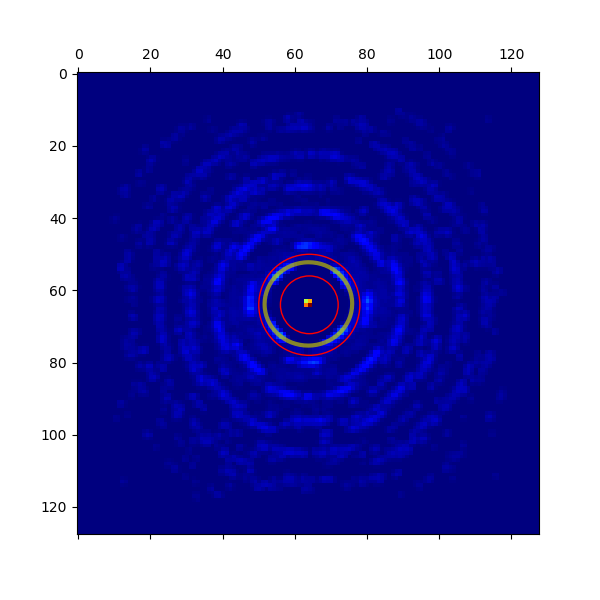

Measured ellipticity = 5.147200210629532%


In [22]:
## Measure elliptical distortion

# Measure with no mask, can optionally apply mask with datamask=mask input
ellipse_params,_ = measure_elliptical_distortion(braggvectormap_shiftcorrected, x0, y0, r_inner, r_outer)
x,y,a,b,theta = ellipse_params

# In a case with degenerate ellipse solutions and a known angle between a pair corrected diffraction bragg peaks:
"""
a0,b0,theta0 == initial guess semi major/minor axis and angle in rad
theta = known angle in rad between a pair of the diffraction peaks after performing elliptical distortion correction.
a,b = constrain_degenerate_ellipse(data, x0, y0, a0, b0, theta0, r_inner, r_outer, phi_known=theta)
"""
# Display params
power = 0.25

# Show
fig,ax=plt.subplots(figsize=(6,6))
ax.matshow(braggvectormap_shiftcorrected**power,cmap='jet')
circle_inner = Circle((y0,x0),radius=r_inner, fill=False,edgecolor='r',linestyle="-")
circle_outer = Circle((y0,x0),radius=r_outer, fill=False,edgecolor='r',linestyle="-")
ellipse = Ellipse((y,x),2*a,2*b,90-np.degrees(theta), fill=False,edgecolor='y',linestyle="-",linewidth=3, alpha=.7)
ax.add_patch(circle_inner)
ax.add_patch(circle_outer)
ax.add_patch(ellipse)
plt.show()

print("Measured ellipticity = {}%".format(100*(max(a,b)/min(a,b)-1)))

100%|██████████| 16384/16384 [00:11<00:00, 1397.75it/s]


<IPython.core.display.Javascript object>


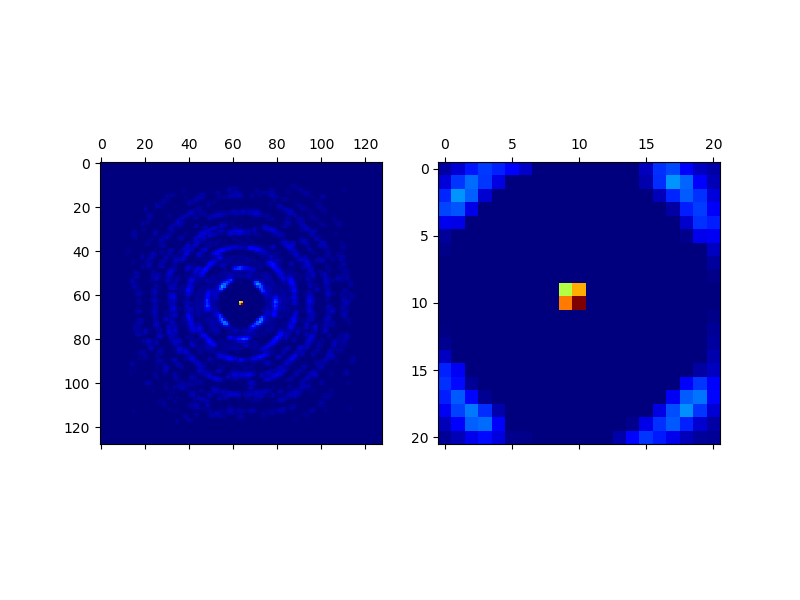

<IPython.core.display.Javascript object>


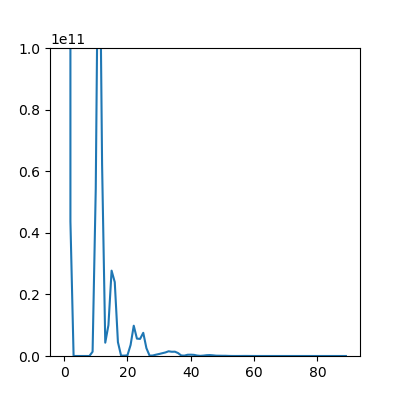

In [23]:
## Apply ellipse correction
corrected_ellipse_params = [x,y,a,b,theta]
braggpeaks_ellipsecorrected = correct_elliptical_distortion(braggpeaks_shiftcorrected, corrected_ellipse_params)

# Get new Bragg vector map and radial integral
braggvectormap_ellipsecorrected = get_bragg_vector_map(braggpeaks_ellipsecorrected,dc.Q_Nx,dc.Q_Ny)
x0,y0 = np.unravel_index(np.argmax(gaussian_filter(braggvectormap_ellipsecorrected,2)),(dc.Q_Nx,dc.Q_Ny))
radial_profile = radial_integral(braggvectormap_ellipsecorrected,x0,y0,dr=1)[0]

# Display params
power = 0.25
rad = 10

# Show
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,6))
ax1.matshow(braggvectormap_ellipsecorrected**power,cmap='jet')
ax2.matshow(braggvectormap_ellipsecorrected[int(x0-rad):int(x0+rad)+1,int(y0-rad):int(y0+rad)+1]**power,cmap='jet')
fig,ax3 = plt.subplots(figsize=(4,4))
ax3.plot(np.arange(len(radial_profile)),radial_profile)
ax3.set_ylim(0,ymax)
plt.show()

<IPython.core.display.Javascript object>


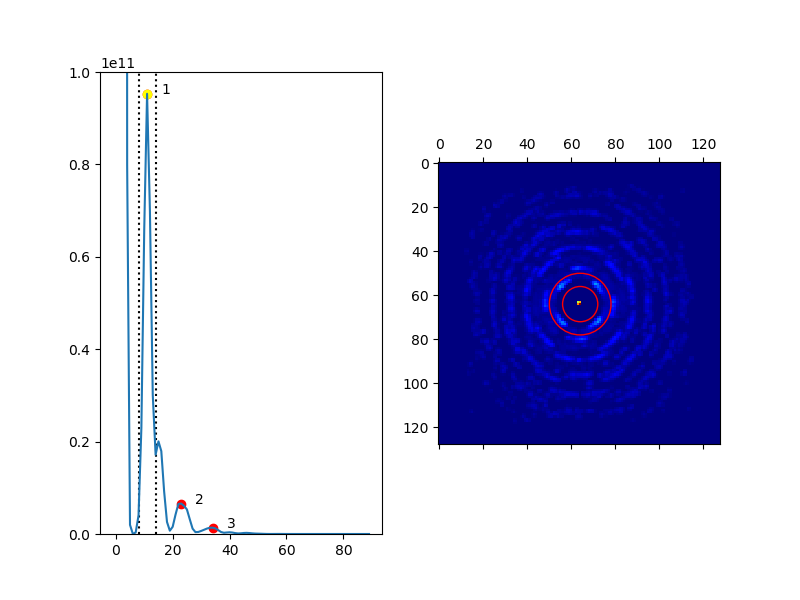

In [24]:
## Show annulus around corrected map

maxima = get_maxima_1D(radial_profile, sigma=sigma, minSpacing=minSpacing,
                       minRelativeIntensity=minRelativeIntensity,
                       relativeToPeak=relativeToPeak)

r_peak = maxima[selected_index]
r_inner = r_peak - annulus_width/2.
r_outer = r_peak + annulus_width/2.

# Show
profile_smoothed = gaussian_filter(radial_profile,sigma)
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,6))
ax1.plot(np.arange(len(profile_smoothed)),profile_smoothed)
ax1.scatter(maxima,profile_smoothed[maxima],color='r')
for i in range(len(maxima)):
    if profile_smoothed[maxima[i]] < ymax:
        ax1.text(maxima[i]+text_offset,profile_smoothed[maxima[i]],'{}'.format(i))
ax1.scatter(r_peak,profile_smoothed[r_peak],color='yellow')
ax1.vlines((r_inner,r_outer),0,ax1.get_ylim()[1],linestyle=":")
ax1.set_ylim(0,ymax)

ax2.matshow(braggvectormap_ellipsecorrected**power,cmap='jet')
circle_inner = Circle((y0,x0),radius=r_inner, fill=False, edgecolor='r', linestyle="-")
circle_outer = Circle((y0,x0),radius=r_outer, fill=False, edgecolor='r', linestyle="-")
ax2.add_patch(circle_inner)
ax2.add_patch(circle_outer)

plt.show()

<IPython.core.display.Javascript object>


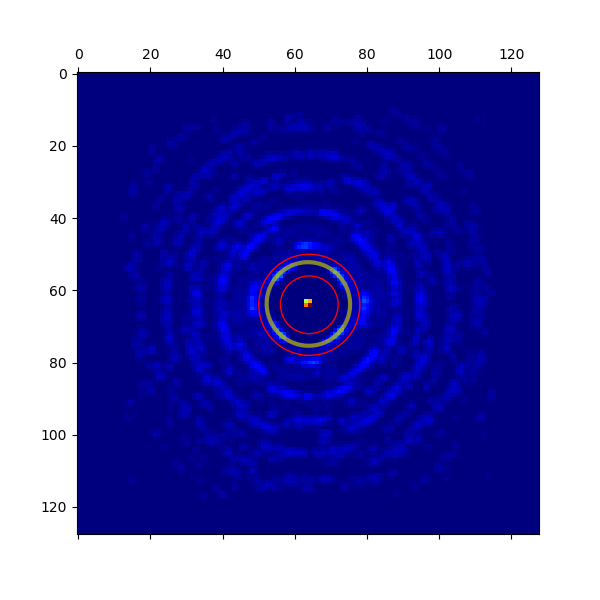

Measured ellipticity = 0.850343513386731%


In [25]:
## Measure corrected elliptical distortion

# Measure with no mask
ellipse_params,_ = measure_elliptical_distortion(braggvectormap_ellipsecorrected, x0, y0, r_inner, r_outer)
x,y,a,b,theta = ellipse_params

# Show
fig,ax=plt.subplots(figsize=(6,6))
ax.matshow(braggvectormap_ellipsecorrected**power,cmap='jet')
circle_inner = Circle((y0,x0),radius=r_inner, fill=False,edgecolor='r',linestyle="-")
circle_outer = Circle((y0,x0),radius=r_outer, fill=False,edgecolor='r',linestyle="-")
ellipse = Ellipse((y,x),2*a,2*b,90-np.degrees(theta), fill=False,edgecolor='y',linestyle="-",linewidth=3, alpha=.7)
ax.add_patch(circle_inner)
ax.add_patch(circle_outer)
ax.add_patch(ellipse)
plt.show()

print("Measured ellipticity = {}%".format(100*(max(a,b)/min(a,b)-1)))

## Classification
Based on classify.ipynb 

### Get Bragg vector map maxima

for labelling the Bragg peaks

In [1]:
'''
Necessary imports:
from scipy.spatial import Voronoi
from py4DSTEM.process.utils import get_maxima_2D, get_voronoi_vertices
from py4DSTEM.process.classification import BraggVectorClassification, get_class_DP
from py4DSTEM.visualize import show_grid,show_class_BPs_grid

Necessary data:
bragg vector map (DiffractionSlice) e.g. braggvectormap_shiftcorrected
bragg peaks () e.g. braggpeaks_shiftcorrected
'''


'\nNecessary imports:\nfrom scipy.spatial import Voronoi\nfrom py4DSTEM.process.utils import get_maxima_2D, get_voronoi_vertices\nfrom py4DSTEM.process.classification import BraggVectorClassification, get_class_DP\nfrom py4DSTEM.visualize import show_grid,show_class_BPs_grid\n\nNecessary data:\nbragg vector map (DiffractionSlice) e.g. braggvectormap_shiftcorrected\nbragg peaks () e.g. braggpeaks_shiftcorrected\n'

In [ ]:
# Get Bragg vector map maxima

sigma = 1
edgeBoundary = 0
minSpacing = 2
minRelativeIntensity = 0.00001
relativeToPeak = 0
maxNumPeaks = 1000
subpixel = True

power = 0.25
scale = 0     # Set scale to 0 to plot all BPs as the same size

maxima_x, maxima_y, maxima_int = get_maxima_2D(braggvectormap_shiftcorrected, sigma=sigma, edgeBoundary=edgeBoundary,
                                               minSpacing=minSpacing, minRelativeIntensity=minRelativeIntensity,
                                               relativeToPeak=relativeToPeak, maxNumPeaks=maxNumPeaks,
                                               subpixel=subpixel)
N = len(maxima_x)
print(N)

# Show
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8,8))
ax1.matshow(braggvectormap_shiftcorrected**power,cmap='jet')
ax2.matshow(braggvectormap_shiftcorrected**power,cmap='jet')
if scale==0:
    ax2.scatter(maxima_y,maxima_x,color='r')
else:
    ax2.scatter(maxima_y,maxima_x,color='r',
                s=scale*maxima_int/np.max(maxima_int))
plt.show()

In [ ]:
# For display - make Voronoi diagram
points = np.vstack((maxima_x,maxima_y)).T
voronoi = Voronoi(points)

# Get vertices
vertices = get_voronoi_vertices(voronoi, dc.Q_Nx, dc.Q_Ny)

# Show
fig,ax=plt.subplots(figsize=(8,8))
ax.matshow(braggvectormap_shiftcorrected**0.25,cmap='jet')
ax.scatter(voronoi.points[:,1],voronoi.points[:,0],color='r')
ax.scatter(voronoi.vertices[:,1],voronoi.vertices[:,0],color='y')
for region in range(len(vertices)):
    vertices_curr = vertices[region]
    for i in range(len(vertices_curr)):
        x0,y0 = vertices_curr[i,:]
        x1,y1 = vertices_curr[(i+1)%len(vertices_curr),:]
        ax.plot((y0,y1),(x0,x1),'w')        
ax.set_xlim([0,braggvectormap_shiftcorrected.shape[1]])
ax.set_ylim([0,braggvectormap_shiftcorrected.shape[0]])
plt.gca().invert_yaxis()
plt.show()

### Classify

In [ ]:
thresh = 0.3                # Determines when to stop adding new BPs to the initial classes
BP_fraction_thresh = 0.1
max_iterations = 200        # Maximum number of initial classes
X_is_boolean = True
n_corr_init = 3

classification = BraggVectorClassification(braggpeaks_shiftcorrected, maxima_x, maxima_y,
                                           #thresh = thresh,
                                           #BP_fraction_thresh = BP_fraction_thresh,
                                           #max_iterations = max_iterations,
                                           X_is_boolean = X_is_boolean)#,
                                           #n_corr_init=n_corr_init)

In [ ]:
classification.get_initial_classes_by_cooccurrence(thresh=0.3,BP_fraction_thresh=0.1,max_iterations=5)

### Visualizing

In [ ]:
# class visualization parameters:
H=2
W=2
axsize=(4,4)

Nc = H*W

In [ ]:
# Get class images
# number of classes shown (i) is set by the H and W specified
show_grid(lambda i: classification.get_class_image(i),H=H,W=W,axsize=axsize)

In [ ]:
# Get class bragg vectors

show_class_BPs_grid(braggvectormap_shiftcorrected,s2=25,min=0,max=2,cmap='jet',H=H,W=W,x=maxima_x,y=maxima_y,get_s=lambda i: classification.get_class_BPs(i),axsize=axsize)

In [ ]:
# Get class average diffraction patterns
class_dps = np.zeros((dc.Q_Nx,dc.Q_Ny,Nc))
for it in range(Nc):
    class_dps[:,:,it] = get_class_DP(dc,classification.get_class_image(it))
show_grid(lambda i: class_dps[:,:,i], H=H, W=W, axsize=axsize, cmap='gray',min=1,max=4)

In [ ]:
# refinement with non-negative matrix factorization (?)
# can view refined classes by looking at "candidates", e.g. get_candidate_class_image instead of get_class_image
classification.nmf(max_iterations=1000)

In [ ]:
show_grid(lambda i: classification.get_candidate_class_image(i),H=H,W=W,axsize=axsize)

In [ ]:
show_class_BPs_grid(braggvectormap_shiftcorrected,s2=25,min=0,max=2,cmap='jet',H=H,W=W,x=maxima_x,y=maxima_y,get_s=lambda i: classification.get_candidate_class_BPs(i),axsize=axsize)

In [ ]:
can_class_dps = np.zeros((dc.Q_Nx,dc.Q_Ny,Nc))
for it in range(Nc):
    can_class_dps[:,:,it] = get_class_DP(dc,classification.get_candidate_class_image(it))
show_grid(lambda i: can_class_dps[:,:,i], H=H, W=W, axsize=axsize, cmap='gray',min=1,max=4)

## Strain Mapping

### Calculate lattice vectors

In [ ]:
"""
Necessary imports:
import py4DSTEM
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter

from py4DSTEM.process.latticevectors import *

Necessary data: 
bragg vector map (diffraction slice)
"""

E:\ProgramFiles\PYTHON\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


<IPython.core.display.Javascript object>


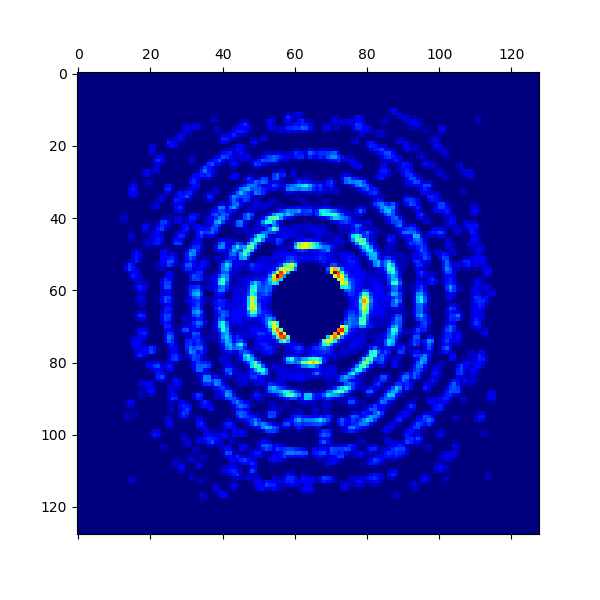

In [26]:
## Get mask for unscattered beam

maskrad = 10 # radius of mask over center beam position

x0,y0 = np.unravel_index(np.argmax(gaussian_filter(braggvectormap_ellipsecorrected,sigma=2)),(dc.Q_Nx,dc.Q_Ny))
ry,rx = np.meshgrid(np.arange(dc.Q_Ny),np.arange(dc.Q_Nx))
mask = ((rx-x0)**2+(ry-y0)**2) > maskrad**2

# Display params
power=0.25

# Show
fig,ax = plt.subplots(figsize=(6,6))
ax.matshow((braggvectormap_ellipsecorrected*mask)**power,cmap='jet')
plt.show()

E:\ProgramFiles\PYTHON\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


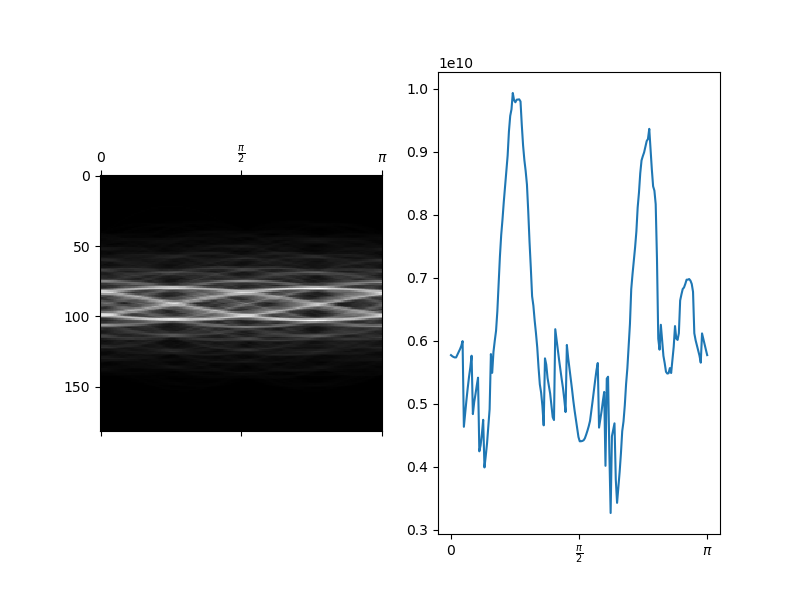

In [27]:
## Perform Randon transform and find scores

# get_radon_scores parameters
N_angles = 200  # number of points in angle array from 0 to pi at which to calculate scores
sigma = 7       # gaussian filter smoothing parameter applied to each theta slice of Radon transform
minSpacing = 10 # min spacing for local maxima identification for each theta slice of Radon transform
minRelativeIntensity = 0.05 # min intensity relative to max intensity along each theta slice of Radon transform

# scores is the average peak intensity along each theta slice of Radon transform, thetas is an array of angles from 0 to pi of 
# length N_angles, sinogram is the Radon tranform of the corrected BVM.

scores, thetas, sinogram = get_radon_scores(braggvectormap_ellipsecorrected, mask, N_angles, sigma, minSpacing, minRelativeIntensity)

# Display params
power = 0.5

# Show
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,6))
ax1.matshow(sinogram**power)
ax1.set_xticks([0,sinogram.shape[1]/2,sinogram.shape[1]])
ax1.set_xticklabels(['0',r'$\frac{\pi}{2}$',r'$\pi$'])
ax2.plot(thetas,scores)
ax2.set_xticks([0,np.pi/2.,np.pi])
ax2.set_xticklabels(['0',r'$\frac{\pi}{2}$',r'$\pi$'])
plt.show()

E:\ProgramFiles\PYTHON\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


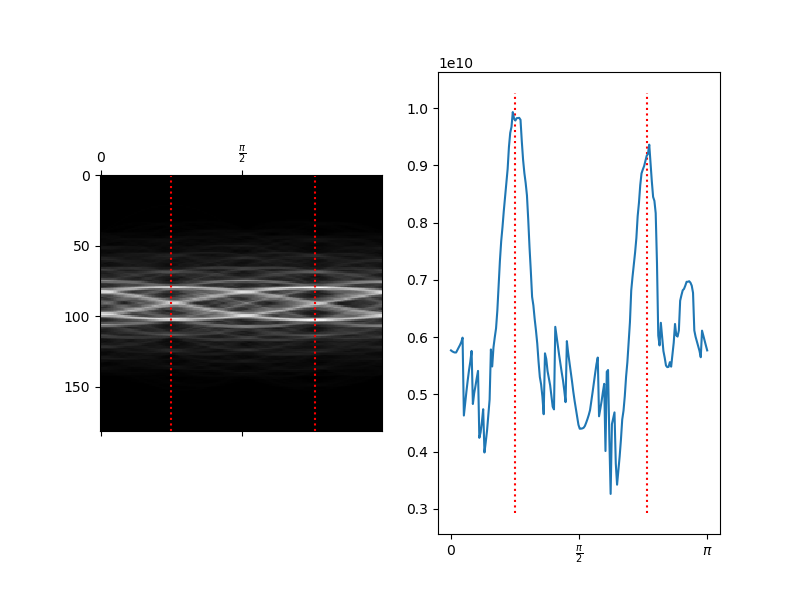

Initial guess at u and v angles is 45.23 and 137.5, respectively.


In [28]:
## Get lattice directions from Radon transform scores

# get_lattice_directions_from_scores parameters
sigma = 2      # gaussian filter smoothing parameter applied to scores
minSpacing = 2 # min spacing of peaks of scores
minRelativeIntensity = 0.0005 # min intensity relative to max intensity of scores
index1 = 0     # index relative to highest intensity peak
index2 = 0     # index relative to second highest intensity peak

u_theta, v_theta = get_lattice_directions_from_scores(thetas, scores, sigma, minSpacing, minRelativeIntensity,
                                                                                         index1, index2)
u_theta_ind = np.argmin(np.abs(thetas-u_theta))
v_theta_ind = np.argmin(np.abs(thetas-v_theta))

# Display params
power = 0.5

# Show
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,6))
ax1.matshow(sinogram**power)
ax1.set_xticks([0,sinogram.shape[1]/2,sinogram.shape[1]])
ax1.vlines((u_theta_ind,v_theta_ind),ax1.get_ylim()[0],ax1.get_ylim()[1],linestyle=":",color='r')
ax1.set_xticklabels(['0',r'$\frac{\pi}{2}$',r'$\pi$'])
ax2.plot(thetas,scores)
ax2.vlines((u_theta,v_theta),ax2.get_ylim()[0],ax2.get_ylim()[1],linestyle=":",color='r')
ax2.set_xticks([0,np.pi/2.,np.pi])
ax2.set_xticklabels(['0',r'$\frac{\pi}{2}$',r'$\pi$'])
plt.show()

print("Initial guess at u and v angles is {:.4} and {:.4}, respectively.".format(np.degrees(u_theta),np.degrees(v_theta)))

E:\ProgramFiles\PYTHON\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


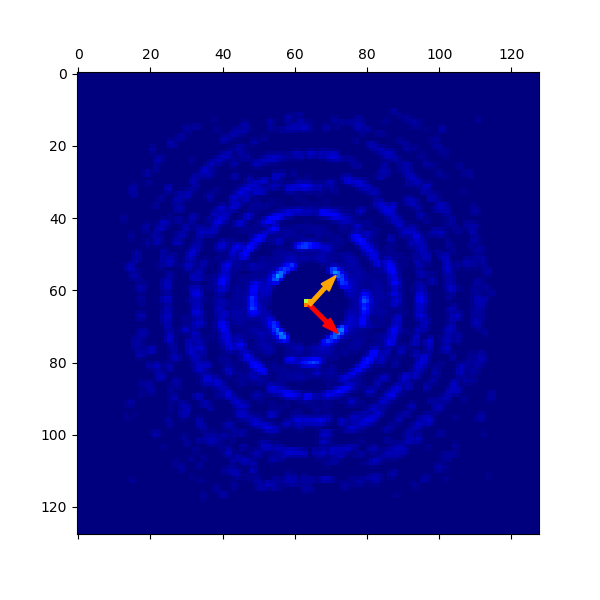

In [29]:
## Get lattice vector lengths

# get_lattice_vector_lengths parameters
spacing_thresh = 1.5       # ignore spacings greater than spacing_thresh times median spacing
sigma = 2                  # gaussian filter smoothing parameter applied to u,v theta slice of Radon transform
minSpacing = 2             # min spacing for local maxima identification for u,v theta slice of Radon transform
minRelativeIntensity = 0.1 # min intensity relative to max intensity along u,v theta slice of Radon transform

u_length, v_length = get_lattice_vector_lengths(u_theta, v_theta, thetas, sinogram,
                                                spacing_thresh, sigma, minSpacing, minRelativeIntensity)

# find x,y values of lattice vectors
x0,y0 = np.unravel_index(np.argmax(gaussian_filter(braggvectormap_ellipsecorrected,sigma=2)),(dc.Q_Nx,dc.Q_Ny))
u_dx = np.cos(u_theta)*u_length
u_dy = np.sin(u_theta)*u_length
v_dx = np.cos(v_theta)*v_length
v_dy = np.sin(v_theta)*v_length

# Display params
power = 0.25

# Show
fig,ax = plt.subplots(figsize=(6,6))
ax.matshow(braggvectormap_ellipsecorrected**power,cmap='jet')
ax.arrow(y0,x0,u_dy,u_dx, color='red',width=1,length_includes_head=True)
ax.arrow(y0,x0,v_dy,v_dx, color='orange',width=1,length_includes_head=True)
plt.show()

In [30]:
## Make pointlist of lattice vectors

coordinates = [('qx',float),('qy',float)]
lattice_vectors = PointList(coordinates, name='lattice_vectors')
lattice_vectors.add_point((u_dx,u_dy))
lattice_vectors.add_point((v_dx,v_dy))

### Fit lattice vectors

In [ ]:
"""
Necessary imports:
import py4DSTEM
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter

from py4DSTEM.process.latticevectors import *

Necessary data: 
bragg vector map (diffraction slice), lattice vectors (point list)
"""

E:\ProgramFiles\PYTHON\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


<IPython.core.display.Javascript object>


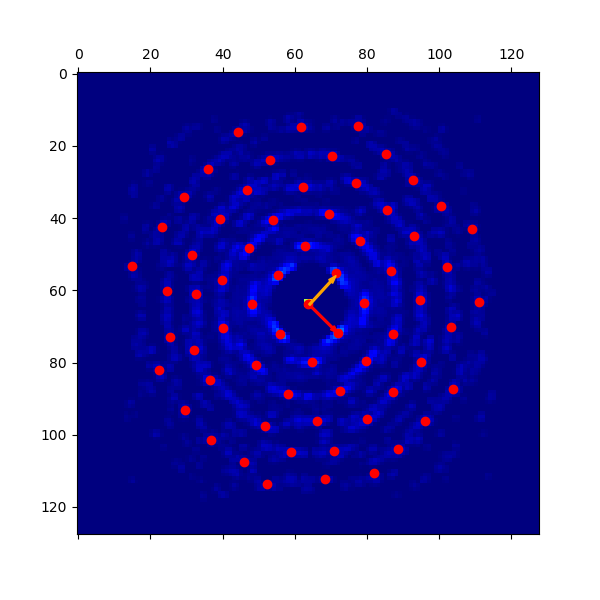

In [31]:
## Find Bragg vector map peak positions

# get_maxima_2D parameters
sigma = 2
minSpacing = 8
minRelativeIntensity = 0.0005
relativeToPeak = 1
maxNumPeaks = 80

maxima_x,maxima_y,_ = get_maxima_2D(braggvectormap_ellipsecorrected, sigma=sigma, minSpacing=minSpacing, minRelativeIntensity=minRelativeIntensity,
                                    relativeToPeak=relativeToPeak, maxNumPeaks=maxNumPeaks)
# Display params
power = 0.25

# Show
fig,ax=plt.subplots(figsize=(6,6))
ax.matshow(braggvectormap_ellipsecorrected**power,cmap='jet')
ax.scatter(maxima_y,maxima_x,color='r')
ax.arrow(y0,x0,u_dy,u_dx, color='red',width=.5,length_includes_head=True)
ax.arrow(y0,x0,v_dy,v_dx, color='orange',width=.5,length_includes_head=True)
plt.show()

E:\ProgramFiles\PYTHON\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


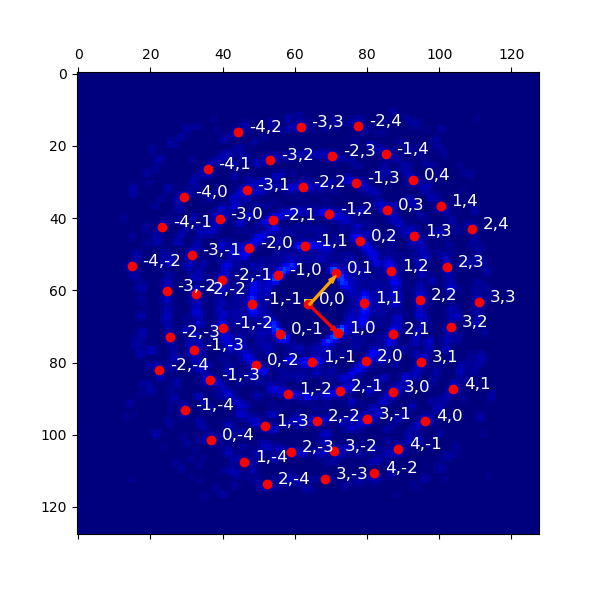

In [32]:
## Calculate indices

h,k,bragg_directions = index_bragg_directions(x0,y0,u_dx,u_dy,v_dx,v_dy,maxima_x,maxima_y)

# display params
textoffset=3

# Show
fig,ax=plt.subplots(figsize=(6,6))
ax.matshow(braggvectormap_ellipsecorrected**.25,cmap='jet')
ax.scatter(bragg_directions.data['qy'],bragg_directions.data['qx'],color='r')
ax.arrow(y0,x0,u_dy,u_dx, color='red',width=.5,length_includes_head=True)
ax.arrow(y0,x0,v_dy,v_dx, color='orange',width=.5,length_includes_head=True)
for i in range(bragg_directions.length):
    ax.text(bragg_directions.data['qy'][i]+textoffset,bragg_directions.data['qx'][i],
            '{},{}'.format(bragg_directions.data['h'][i],bragg_directions.data['k'][i]),
            color='w',size=12)
plt.show()

In [33]:
## Fit Lattice vectors to each diffraction pattern

x0,y0 = np.unravel_index(np.argmax(braggvectormap_ellipsecorrected),braggvectormap_ellipsecorrected.shape)

# fit_lattice_vectors_all_DPs parameters
maxPeakSpacing = 8 # max distance of a bragg peak and an index point
minNumPeaks = 6    # must measure minNumPeaks peaks within maxPeakSpacing indices otherwise mask data point

uv_map = fit_lattice_vectors_all_DPs(braggpeaks_ellipsecorrected, bragg_directions, x0, y0, maxPeakSpacing, minNumPeaks)

# May also add additional real space mask if desired with:
#fit_lattice_vectors_masked(braggpeaks_ellipsecorrected, bragg_directions, x0, y0, mask, maxPeakSpacing, minNumPeaks)

100%|██████████| 16384/16384 [00:04<00:00, 3442.19it/s]


### Calculate strain maps

In [ ]:
"""
Necessary imports:
import py4DSTEM
import numpy as np
import matplotlib.pyplot as plt

from py4DSTEM.process.latticevectors import *

Necessary data: 
lattice vector map
"""

E:\ProgramFiles\PYTHON\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


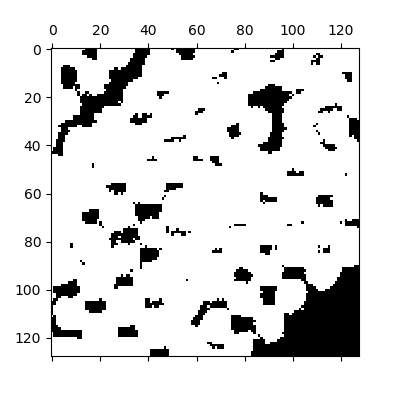

In [34]:
## Specify a region over which the median lattice will be used as the reference lattice
## Here we use the whole image

mask = uv_map.slices['mask'].astype(bool)

fig,ax = plt.subplots(figsize=(4,4))
ax.matshow(mask,cmap='gray')
plt.show()

In [35]:
## Calculate strain

strain_map = get_strain_from_reference_region(mask,uv_map)

### Visualizing strain maps 

In [ ]:
"""
Necessary imports:
import py4DSTEM
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import medfilt

from py4DSTEM.process.latticevectors import *

Necessary data: 
strain map
"""

E:\ProgramFiles\PYTHON\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


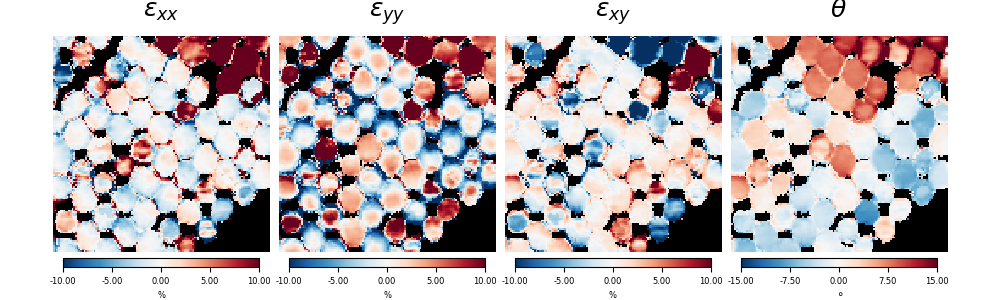

In [36]:
"""
Here we show off a few options for displaying strain maps. It is important to consider a possible 
rotation/flip between the real plane and diffraction plane before over interpretting the strain maps. 
An example of the effect of rotation is shown.
"""
# Plot data
# Unfiltered
# Horizontal layout

titlesize=18
ticklabelsize=6

# Set colorscales
automate_colorscale = False
n_stds=3

e_xx_range = [-10,10] # In percentage
e_yy_range = [-10,10] # In percentage
e_xy_range = [-10,10] # In percentage
theta_range = [-15,15] # In degrees

# Mask if you don't already have one
# mask = strain_map.slices['mask']

# Get smoothed image, mask, and colorscale ranges
plot_mask = np.ma.masked_where(mask, np.ones_like(mask))

e_xx_ave, e_xx_std = np.average(strain_map.slices['e_xx'][mask]),np.std(strain_map.slices['e_xx'][mask])
e_yy_ave, e_yy_std = np.average(strain_map.slices['e_yy'][mask]),np.std(strain_map.slices['e_yy'][mask])
e_xy_ave, e_xy_std = np.average(strain_map.slices['e_xy'][mask]),np.std(strain_map.slices['e_xy'][mask])
theta_ave, theta_std = np.average(strain_map.slices['theta'][mask]),np.std(strain_map.slices['theta'][mask])

if automate_colorscale:
    e_xx_range = [-n_stds*e_xx_std*100,n_stds*e_xx_std*100]
    e_yy_range = [-n_stds*e_yy_std*100,n_stds*e_yy_std*100]
    e_xy_range = [-n_stds*e_xy_std*100,n_stds*e_xy_std*100]
    theta_range = [-n_stds*theta_std*180./np.pi,n_stds*theta_std*180/np.pi]


    
### Plot ###
fig = plt.figure(figsize=(10,3))
           
gs = gridspec.GridSpec(2, 12, width_ratios=[1,20,1,1,20,1,1,20,1,1,20,1], height_ratios=[24, 1])
gs.update(left=0.05, right=0.95, wspace=0.05, hspace=0.05)
ax1 = plt.subplot(gs[0,0:3])
ax2 = plt.subplot(gs[0,3:6])
ax3 = plt.subplot(gs[0,6:9,])
ax4 = plt.subplot(gs[0,9:12])

cbax1 = plt.subplot(gs[1,1])
cbax2 = plt.subplot(gs[1,4])
cbax3 = plt.subplot(gs[1,7,])
cbax4 = plt.subplot(gs[1,10])
    
cax1 = ax1.matshow(strain_map.slices['e_xx'],vmin=e_xx_range[0]/100., vmax=e_xx_range[1]/100., cmap="RdBu_r")
cax2 = ax2.matshow(strain_map.slices['e_yy'],vmin=e_yy_range[0]/100., vmax=e_yy_range[1]/100., cmap="RdBu_r")
cax3 = ax3.matshow(strain_map.slices['e_xy'],vmin=e_xy_range[0]/100., vmax=e_xy_range[1]/100., cmap="RdBu_r")
cax4 = ax4.matshow(strain_map.slices['theta'],vmin=theta_range[0]*np.pi/180., vmax=theta_range[1]*np.pi/180., cmap="RdBu_r")

# Black overlay
ax1.matshow(plot_mask,cmap='gray')
ax2.matshow(plot_mask,cmap='gray')
ax3.matshow(plot_mask,cmap='gray')
ax4.matshow(plot_mask,cmap='gray')
    
# Colorbars

cb1 = plt.colorbar(cax1, cax=cbax1, ticks=np.linspace(e_xx_range[0]/100.,e_xx_range[1]/100.,5,endpoint=True), orientation='horizontal')
cb2 = plt.colorbar(cax2, cax=cbax2, ticks=np.linspace(e_yy_range[0]/100.,e_yy_range[1]/100.,5,endpoint=True), orientation='horizontal')
cb3 = plt.colorbar(cax3, cax=cbax3, ticks=np.linspace(e_xy_range[0]/100.,e_xy_range[1]/100.,5,endpoint=True), orientation='horizontal')
cb4 = plt.colorbar(cax4, cax=cbax4, ticks=np.linspace(theta_range[0]*np.pi/180.,theta_range[1]*np.pi/180.,5,endpoint=True), orientation='horizontal')

cb1.ax.set_xticklabels(['{:.2f}'.format(val) for val in np.linspace(e_xx_range[0],e_xx_range[1],5,endpoint=True)],size=ticklabelsize)
cb2.ax.set_xticklabels(['{:.2f}'.format(val) for val in np.linspace(e_yy_range[0],e_yy_range[1],5,endpoint=True)],size=ticklabelsize)
cb3.ax.set_xticklabels(['{:.2f}'.format(val) for val in np.linspace(e_xy_range[0],e_xy_range[1],5,endpoint=True)],size=ticklabelsize)
cb4.ax.set_xticklabels(['{:.2f}'.format(theta) for theta in np.linspace(theta_range[0],theta_range[1],5,endpoint=True)],size=ticklabelsize)

cbax1.set_xlabel("%", size=ticklabelsize, rotation=0)
cbax2.set_xlabel("%", size=ticklabelsize, rotation=0)
cbax3.set_xlabel("%", size=ticklabelsize, rotation=0)
cbax4.set_xlabel(r"$^\circ$", size=2*ticklabelsize, rotation=0)

ax1.set_title(r'$\epsilon_{xx}$',size=titlesize)
ax2.set_title(r'$\epsilon_{yy}$',size=titlesize)
ax3.set_title(r'$\epsilon_{xy}$',size=titlesize)
ax4.set_title(r'$\theta$',size=titlesize)

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')

plt.show()

E:\ProgramFiles\PYTHON\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


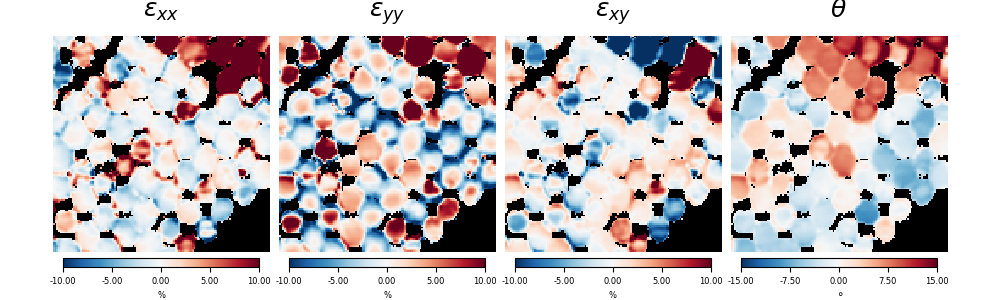

In [37]:
# Plot data
# Median filtering and gaussian smoothing
# Horizontal layout

sigma = .8
titlesize=18
ticklabelsize=6

# Set colorscales
automate_colorscale = False
n_stds=3

e_xx_range = [-10,10] # In percentage
e_yy_range = [-10,10] # In percentage
e_xy_range = [-10,10] # In percentage
theta_range = [-15,15] # In degrees



# Get smoothed image, mask, and colorscale ranges
plot_mask = np.ma.masked_where(mask, np.ones_like(mask))

e_xx_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_map.slices['e_xx'], medfilt(np.where(mask,strain_map.slices['e_xx'],0),kernel_size=3)),sigma),0)
e_yy_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_map.slices['e_yy'], medfilt(np.where(mask,strain_map.slices['e_yy'],0),kernel_size=3)),sigma),0)
e_xy_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_map.slices['e_xy'], medfilt(np.where(mask,strain_map.slices['e_xy'],0),kernel_size=3)),sigma),0)
theta_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_map.slices['theta'], medfilt(np.where(mask,strain_map.slices['theta'],0),kernel_size=3)),sigma),0)

e_xx_ave, e_xx_std = np.average(e_xx_smoothed[mask]),np.std(e_xx_smoothed[mask])
e_yy_ave, e_yy_std = np.average(e_yy_smoothed[mask]),np.std(e_yy_smoothed[mask])
e_xy_ave, e_xy_std = np.average(e_xy_smoothed[mask]),np.std(e_xy_smoothed[mask])
theta_ave, theta_std = np.average(theta_smoothed[mask]),np.std(theta_smoothed[mask])

if automate_colorscale:
    e_xx_range = [-n_stds*e_xx_std*100,n_stds*e_xx_std*100]
    e_yy_range = [-n_stds*e_yy_std*100,n_stds*e_yy_std*100]
    e_xy_range = [-n_stds*e_xy_std*100,n_stds*e_xy_std*100]
    theta_range = [-n_stds*theta_std*180./np.pi,n_stds*theta_std*180/np.pi]


    
### Plot ###
fig = plt.figure(figsize=(10,3))
           
gs = gridspec.GridSpec(2, 12, width_ratios=[1,20,1,1,20,1,1,20,1,1,20,1], height_ratios=[24, 1])
gs.update(left=0.05, right=0.95, wspace=0.05, hspace=0.05)
ax1 = plt.subplot(gs[0,0:3])
ax2 = plt.subplot(gs[0,3:6])
ax3 = plt.subplot(gs[0,6:9,])
ax4 = plt.subplot(gs[0,9:12])

cbax1 = plt.subplot(gs[1,1])
cbax2 = plt.subplot(gs[1,4])
cbax3 = plt.subplot(gs[1,7,])
cbax4 = plt.subplot(gs[1,10])
    
cax1 = ax1.matshow(e_xx_smoothed,vmin=e_xx_range[0]/100., vmax=e_xx_range[1]/100., cmap="RdBu_r")
cax2 = ax2.matshow(e_yy_smoothed,vmin=e_yy_range[0]/100., vmax=e_yy_range[1]/100., cmap="RdBu_r")
cax3 = ax3.matshow(e_xy_smoothed,vmin=e_xy_range[0]/100., vmax=e_xy_range[1]/100., cmap="RdBu_r")
cax4 = ax4.matshow(theta_smoothed,vmin=theta_range[0]*np.pi/180., vmax=theta_range[1]*np.pi/180., cmap="RdBu_r")

# Black overlay
ax1.matshow(plot_mask,cmap='gray')
ax2.matshow(plot_mask,cmap='gray')
ax3.matshow(plot_mask,cmap='gray')
ax4.matshow(plot_mask,cmap='gray')
    
# Colorbars

cb1 = plt.colorbar(cax1, cax=cbax1, ticks=np.linspace(e_xx_range[0]/100.,e_xx_range[1]/100.,5,endpoint=True), orientation='horizontal')
cb2 = plt.colorbar(cax2, cax=cbax2, ticks=np.linspace(e_yy_range[0]/100.,e_yy_range[1]/100.,5,endpoint=True), orientation='horizontal')
cb3 = plt.colorbar(cax3, cax=cbax3, ticks=np.linspace(e_xy_range[0]/100.,e_xy_range[1]/100.,5,endpoint=True), orientation='horizontal')
cb4 = plt.colorbar(cax4, cax=cbax4, ticks=np.linspace(theta_range[0]*np.pi/180.,theta_range[1]*np.pi/180.,5,endpoint=True), orientation='horizontal')

cb1.ax.set_xticklabels(['{:.2f}'.format(val) for val in np.linspace(e_xx_range[0],e_xx_range[1],5,endpoint=True)],size=ticklabelsize)
cb2.ax.set_xticklabels(['{:.2f}'.format(val) for val in np.linspace(e_yy_range[0],e_yy_range[1],5,endpoint=True)],size=ticklabelsize)
cb3.ax.set_xticklabels(['{:.2f}'.format(val) for val in np.linspace(e_xy_range[0],e_xy_range[1],5,endpoint=True)],size=ticklabelsize)
cb4.ax.set_xticklabels(['{:.2f}'.format(theta) for theta in np.linspace(theta_range[0],theta_range[1],5,endpoint=True)],size=ticklabelsize)

cbax1.set_xlabel("%", size=ticklabelsize, rotation=0)
cbax2.set_xlabel("%", size=ticklabelsize, rotation=0)
cbax3.set_xlabel("%", size=ticklabelsize, rotation=0)
cbax4.set_xlabel(r"$^\circ$", size=2*ticklabelsize, rotation=0)

ax1.set_title(r'$\epsilon_{xx}$',size=titlesize)
ax2.set_title(r'$\epsilon_{yy}$',size=titlesize)
ax3.set_title(r'$\epsilon_{xy}$',size=titlesize)
ax4.set_title(r'$\theta$',size=titlesize)

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')

plt.show()

E:\ProgramFiles\PYTHON\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


<IPython.core.display.Javascript object>


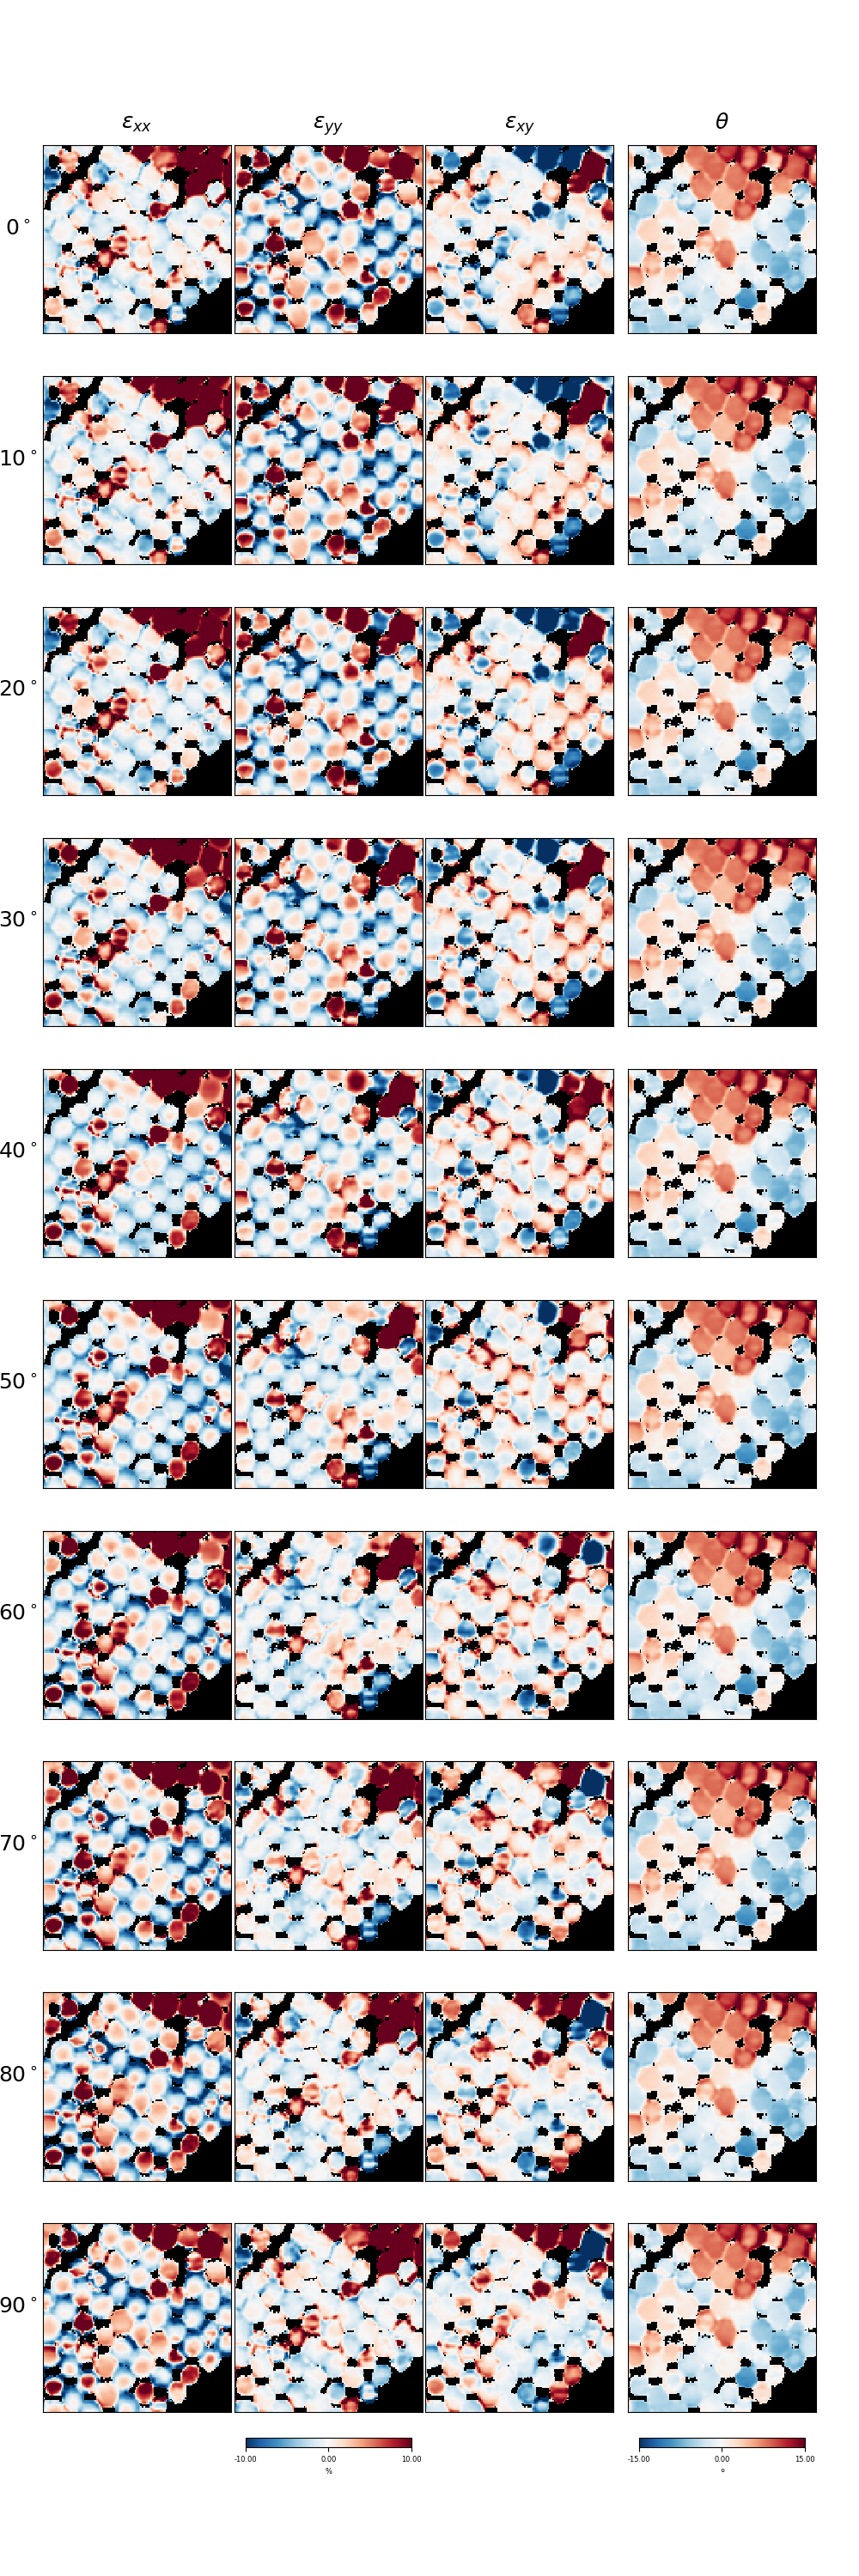

In [38]:
# Rotate coordinate system - multiple rotations
# Median filtering and gaussian smoothing
# Horizontal layout

rotations = [0,10,20,30,40,50,60,70,80,90] # in degrees
sigma = .8
titlesize=18
rotationlabelsize=18
ticklabelsize=6

e_range = [-10,10] # In percentage
theta_range = [-15,15] # In degrees


# Figure
fig = plt.figure(figsize=(10,3*len(rotations)))
gs = gridspec.GridSpec(len(rotations)+1, 13, width_ratios=[1,20,1,1,20,1,1,20,1,1,1,20,1], height_ratios=[24]*len(rotations)+[1])
gs.update(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.05, hspace=0.05)

for i in range(len(rotations)):
    rotation = rotations[i]

     # Rotate data
    costheta = np.cos(rotation*np.pi/180.)
    sintheta = np.sin(rotation*np.pi/180.)
    e_xx_rotated = np.empty_like(strain_map.slices['e_xx'])
    e_yy_rotated = np.empty_like(strain_map.slices['e_yy'])
    e_xy_rotated = np.empty_like(strain_map.slices['e_xy'])
    for Rx in range(strain_map.R_Nx):
        for Ry in range(strain_map.R_Ny):
            e_xx_rotated[Rx,Ry] = costheta**2*strain_map.slices['e_xx'][Rx,Ry] - 2*costheta*sintheta*strain_map.slices['e_xy'][Rx,Ry] + sintheta**2*strain_map.slices['e_yy'][Rx,Ry]
            e_yy_rotated[Rx,Ry] = sintheta**2*strain_map.slices['e_xx'][Rx,Ry] + 2*costheta*sintheta*strain_map.slices['e_xy'][Rx,Ry] + costheta**2*strain_map.slices['e_yy'][Rx,Ry]
            e_xy_rotated[Rx,Ry] = costheta*sintheta*(strain_map.slices['e_xx'][Rx,Ry]-strain_map.slices['e_yy'][Rx,Ry]) + (costheta**2-sintheta**2)*strain_map.slices['e_xy'][Rx,Ry]
    
    # Get smoothed image, mask, and colorscale ranges
    plot_mask = np.ma.masked_where(mask, np.ones_like(mask))

    e_xx_smoothed = np.where(mask,gaussian_filter(np.where(mask, e_xx_rotated, medfilt(np.where(mask,strain_map.slices['e_xx'],0),kernel_size=3)),sigma),0)
    e_yy_smoothed = np.where(mask,gaussian_filter(np.where(mask, e_yy_rotated, medfilt(np.where(mask,strain_map.slices['e_yy'],0),kernel_size=3)),sigma),0)
    e_xy_smoothed = np.where(mask,gaussian_filter(np.where(mask, e_xy_rotated, medfilt(np.where(mask,strain_map.slices['e_xy'],0),kernel_size=3)),sigma),0)
    theta_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_map.slices['theta'], medfilt(np.where(mask,strain_map.slices['theta'],0),kernel_size=3)),sigma),0)

    e_xx_ave = np.average(e_xx_smoothed[mask])
    e_yy_ave = np.average(e_yy_smoothed[mask])
    e_xy_ave = np.average(e_xy_smoothed[mask])
    theta_ave = np.average(theta_smoothed[mask])


    ### Plot ###

    ax1 = plt.subplot(gs[i,0:3])
    ax2 = plt.subplot(gs[i,3:6])
    ax3 = plt.subplot(gs[i,6:9,])
    ax4 = plt.subplot(gs[i,10:13])

    cax1 = ax1.matshow(e_xx_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu_r")
    cax2 = ax2.matshow(e_yy_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu_r")
    cax3 = ax3.matshow(e_xy_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu_r")
    cax4 = ax4.matshow(theta_smoothed,vmin=theta_range[0]*np.pi/180., vmax=theta_range[1]*np.pi/180., cmap="RdBu_r")

    # Black overlay
    ax1.matshow(plot_mask,cmap='gray')
    ax2.matshow(plot_mask,cmap='gray')
    ax3.matshow(plot_mask,cmap='gray')
    ax4.matshow(plot_mask,cmap='gray')

    # Row labels
    ax1.set_ylabel(r"{}$^\circ$      ".format(rotation), size=rotationlabelsize, rotation=0)
    
    # Column labels
    if i==0:
        ax1.set_title(r'$\epsilon_{xx}$',size=titlesize)
        ax2.set_title(r'$\epsilon_{yy}$',size=titlesize)
        ax3.set_title(r'$\epsilon_{xy}$',size=titlesize)
        ax4.set_title(r'$\theta$',size=titlesize)

    # Colorbars
    if i==len(rotations)-1:
        cbax1 = plt.subplot(gs[i+1,1])
        cbax2 = plt.subplot(gs[i+1,4])
        cbax3 = plt.subplot(gs[i+1,7,])
        cbax4 = plt.subplot(gs[i+1,11])

        cb1 = plt.colorbar(cax1, cax=cbax1, ticks=np.linspace(e_range[0]/100.,e_range[1]/100.,3,endpoint=True), orientation='horizontal')
        cb2 = plt.colorbar(cax2, cax=cbax2, ticks=np.linspace(e_range[0]/100.,e_range[1]/100.,3,endpoint=True), orientation='horizontal')
        cb3 = plt.colorbar(cax3, cax=cbax3, ticks=np.linspace(e_range[0]/100.,e_range[1]/100.,3,endpoint=True), orientation='horizontal')
        cb4 = plt.colorbar(cax4, cax=cbax4, ticks=np.linspace(theta_range[0]*np.pi/180.,theta_range[1]*np.pi/180.,3,endpoint=True), orientation='horizontal')

        cb1.ax.set_xticklabels(['{:.2f}'.format(val) for val in np.linspace(e_range[0],e_range[1],3,endpoint=True)],size=ticklabelsize)
        cb2.ax.set_xticklabels(['{:.2f}'.format(val) for val in np.linspace(e_range[0],e_range[1],3,endpoint=True)],size=ticklabelsize)
        cb3.ax.set_xticklabels(['{:.2f}'.format(val) for val in np.linspace(e_range[0],e_range[1],3,endpoint=True)],size=ticklabelsize)
        cb4.ax.set_xticklabels(['{:.2f}'.format(theta) for theta in np.linspace(theta_range[0],theta_range[1],3,endpoint=True)],size=ticklabelsize)

        cbax1.set_xlabel("%", size=ticklabelsize, rotation=0)
        cbax2.set_xlabel("%", size=ticklabelsize, rotation=0)
        cbax3.set_xlabel("%", size=ticklabelsize, rotation=0)
        cbax4.set_xlabel(r"$^\circ$", size=2*ticklabelsize, rotation=0)

        cb1.remove()
        cb3.remove()
    
    ax1.xaxis.set_ticks([]) 
    ax1.yaxis.set_ticks([]) 
    ax2.xaxis.set_ticks([]) 
    ax2.yaxis.set_ticks([]) 
    ax3.xaxis.set_ticks([]) 
    ax3.yaxis.set_ticks([]) 
    ax4.xaxis.set_ticks([]) 
    ax4.yaxis.set_ticks([]) 

plt.show()

## Amorphous Strain Mapping

## RDF

## DPC

## Ptychography

## Saving & Importing Processed Data

In [19]:
"""
Save all of your processed data to a .h5 file using {save} and {append}! 
Access these files again through {py4DSTEM.file.io.native.read_py4DSTEM}. 
"""

'\nSave all of your processed data to a .h5 file using {save} and {append}! \nAccess these files again through {py4DSTEM.file.io.native.read_py4DSTEM}. \n'

In [39]:
## Probe and Probe Kernel
probedata = np.zeros((dc.Q_Nx,dc.Q_Ny,2))
probedata[:,:,0] = probe
probedata[:,:,1] = probe_kernel
probekernel_diffslice = DiffractionSlice(data=probedata, name='probe',slicelabels=['probe','probe_kernel'])
save(sp+savename,probekernel_diffslice)

## Braggpeaks and Vector map
braggvectormap_diffslice = py4DSTEM.file.datastructure.DiffractionSlice(braggvectormap_uncorrected, name='braggvectormap_uncorrected')
append(sp+savename, [braggpeaks_uncorrected,braggvectormap_diffslice])

## Diffraction shifts
data = np.zeros((dc.R_Nx,dc.R_Ny,2))
data[:,:,0] = xshifts_fit
data[:,:,1] = yshifts_fit
diffractionshifts = RealSlice(data, slicelabels=('x_shifts','y_shifts'), name='diffraction_shifts')

## Shift Corrected Braggpeaks and Vector map
braggvectormap_corrected_diffslice = DiffractionSlice(braggvectormap_shiftcorrected, name='braggvectormap_shiftcorrected')
append(sp+savename, [diffractionshifts, braggvectormap_corrected_diffslice, braggpeaks_shiftcorrected])

## Elliptical Distortion Corrected
braggvectormap_corrected_diffslice = DiffractionSlice(braggvectormap_ellipsecorrected, name='braggvectormap_shiftcorrected_ellipsecorrected')
append(sp+savename, [braggvectormap_corrected_diffslice, braggpeaks_ellipsecorrected])

## Initial lattice vectors
append(sp+savename, lattice_vectors)

## UV map
append(sp+savename,uv_map)

## Strain maps
append(sp+savename,strain_map)

Done.


  2%|▏         | 246/16384 [00:00<00:06, 2441.58it/s]

Done.


  1%|▏         | 244/16384 [00:00<00:06, 2422.31it/s]

Done.


100%|██████████| 16384/16384 [00:06<00:00, 2480.74it/s]

Done.
Done.
Done.
Done.


In [41]:
## Check that everything saved properly
py4DSTEM.file.io.native.read_py4DSTEM(sp+savename)

Index     Type              Shape                   Name                                                  
-----     ----              -----                   ----                                                  
  0       DiffractionSlice  (128, 128)              braggvectormap_shiftcorrected                         
  1       DiffractionSlice  (128, 128)              braggvectormap_shiftcorrected_ellipsecorrected        
  2       DiffractionSlice  (128, 128)              braggvectormap_uncorrected                            
  3       DiffractionSlice  (128, 128, 2)           probe                                                 
  4       RealSlice         (128, 128, 2)           diffraction_shifts                                    
  5       RealSlice         (128, 128, 5)           strain_map                                            
  6       RealSlice         (128, 128, 6)           uv_map                                                
  7       PointList         (2, 2)   

(None, None)

E:\ProgramFiles\PYTHON\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


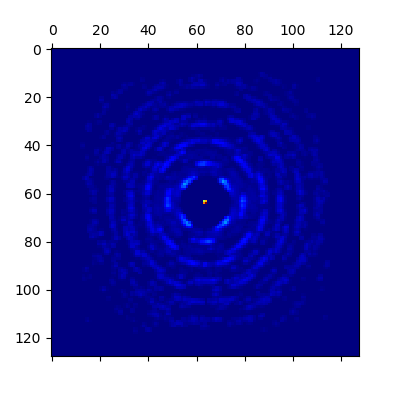

In [47]:
## Load files directly from .h5 
checkbvm,_ = py4DSTEM.file.io.native.read_py4DSTEM(sp+savename, data_id=1)

fig,ax = plt.subplots(figsize=(4,4))
ax.matshow(checkbvm.data**0.25,cmap='jet')
plt.show()